In [101]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, SimpleRNN
from tensorflow.keras.layers import Embedding, LSTM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix, classification_report

In [102]:
df= pd.read_csv("/kaggle/input/hdfs-log-structured/HDFS.log_structured.csv")
df.head(10)

,LineId,Date,Time,Pid,Level,Component,Content,EventId,EventTemplate
0,1,81109,203518,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>
1,2,81109,203518,35,INFO,dfs.FSNamesystem,BLOCK* NameSystem.allocateBlock: /mnt/hadoop/m...,E22,BLOCK* NameSystem.allocateBlock:<*>
2,3,81109,203519,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>
3,4,81109,203519,145,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>
4,5,81109,203519,145,INFO,dfs.DataNode$PacketResponder,PacketResponder 1 for block blk_-1608999687919...,E11,PacketResponder <*> for block <*> terminating
5,6,81109,203519,145,INFO,dfs.DataNode$PacketResponder,PacketResponder 2 for block blk_-1608999687919...,E11,PacketResponder <*> for block <*> terminating
6,7,81109,203519,145,INFO,dfs.DataNode$PacketResponder,Received block blk_-1608999687919862906 of siz...,E9,Received block <*> of size <*> from /<*>
7,8,81109,203519,145,INFO,dfs.DataNode$PacketResponder,Received block blk_-1608999687919862906 of siz...,E9,Received block <*> of size <*> from /<*>
8,9,81109,203519,147,INFO,dfs.DataNode$PacketResponder,PacketResponder 0 for block blk_-1608999687919...,E11,PacketResponder <*> for block <*> terminating
9,10,81109,203519,147,INFO,dfs.DataNode$PacketResponder,Received block blk_-1608999687919862906 of siz...,E9,Received block <*> of size <*> from /<*>


In [103]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104815 entries, 0 to 104814
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   LineId         104815 non-null  int64 
 1   Date           104815 non-null  int64 
 2   Time           104815 non-null  int64 
 3   Pid            104815 non-null  int64 
 4   Level          104815 non-null  object
 5   Component      104815 non-null  object
 6   Content        104815 non-null  object
 7   EventId        104815 non-null  object
 8   EventTemplate  104815 non-null  object
dtypes: int64(4), object(5)
memory usage: 7.2+ MB


In [104]:
# Check for duplicates
duplicates = df[df.duplicated()]

# Display duplicates
print("Duplicate rows:")
print(duplicates)

Duplicate rows:
Empty DataFrame
Columns: [LineId, Date, Time, Pid, Level, Component, Content, EventId, EventTemplate]
Index: []


In [105]:
# Check the number of unique values in each column
unique_counts = df.nunique()

# Display the unique value counts for each column
print(unique_counts)


LineId           104815
Date                  1
Time               1406
Pid                 595
Level                 2
Component             8
Content           96247
EventId              19
EventTemplate        19
dtype: int64


In [106]:
unique_levels = df['Level'].unique()
unique_components = df['Component'].unique()

print("Unique Levels:")
print(unique_levels)

print("\nUnique Components:")
print(unique_components)


Unique Levels:
['INFO' 'WARN']

Unique Components:
['dfs.DataNode$DataXceiver' 'dfs.FSNamesystem'
 'dfs.DataNode$PacketResponder' 'dfs.DataNode$DataTransfer' 'dfs.DataNode'
 'dfs.DataBlockScanner' 'dfs.FSDataset' 'dfs.DataNode$BlockReceiver']


In [107]:

unique_event_ids = df['EventId'].unique()

# Convert the unique Event IDs to a list
unique_event_ids_list = list(unique_event_ids)

# Display the list of unique Event IDs
print(unique_event_ids_list)


['E5', 'E22', 'E11', 'E9', 'E26', 'E6', 'E16', 'E18', 'E25', 'E3', 'E2', 'E7', 'E10', 'E21', 'E13', 'E14', 'E27', 'E8', 'E15']


In [108]:

unique_event_templates = df['EventTemplate'].unique()

# Convert the unique Event Templates to a list
unique_event_templates_list = list(unique_event_templates)

# Display the list of unique Event Templates
print(unique_event_templates_list)


['Receiving block <*> src: /<*> dest: /<*>', 'BLOCK* NameSystem.allocateBlock:<*>', 'PacketResponder <*> for block <*> terminating', 'Received block <*> of size <*> from /<*>', 'BLOCK* NameSystem.addStoredBlock: blockMap updated: <*> is added to <*> size <*>', 'Received block <*> src: /<*> dest: /<*> of size <*>', '<*>:Transmitted block <*> to /<*>', '<*> Starting thread to transfer block <*> to <*>', 'BLOCK* ask <*> to replicate <*> to datanode(s) <*>', '<*> Served block <*> to /<*>', 'Verification succeeded for <*>', 'writeBlock <*> received exception <*>', 'PacketResponder <*> <*> Exception <*>', 'Deleting block <*> file <*>', 'Receiving empty packet for block <*>', 'Exception in receiveBlock for block <*> <*>', 'BLOCK* NameSystem.addStoredBlock: Redundant addStoredBlock request received for <*> on <*> size <*>', 'PacketResponder <*> for block <*> Interrupted.', 'Changing block file offset of block <*> from <*> to <*> meta file offset to <*>']


In [109]:
unique_event_templates_list = [
    'Receiving block <*> src: /<*> dest: /<*>',
    'BLOCK* NameSystem.allocateBlock:<*>',
    'PacketResponder <*> for block <*> terminating',
    'Received block <*> of size <*> from /<*>',
    'BLOCK* NameSystem.addStoredBlock: blockMap updated: <*> is added to <*> size <*>',
    'Received block <*> src: /<*> dest: /<*> of size <*>',
    '<*>:Transmitted block <*> to /<*>',
    '<*> Starting thread to transfer block <*> to <*>',
    'BLOCK* ask <*> to replicate <*> to datanode(s) <*>',
    '<*> Served block <*> to /<*>',
    'Verification succeeded for <*>',
    'writeBlock <*> received exception <*>',
    'PacketResponder <*> <*> Exception <*>',
    'Deleting block <*> file <*>',
    'Receiving empty packet for block <*>',
    'Exception in receiveBlock for block <*> <*>',
    'BLOCK* NameSystem.addStoredBlock: Redundant addStoredBlock request received for <*> on <*> size <*>',
    'PacketResponder <*> for block <*> Interrupted.',
    'Changing block file offset of block <*> from <*> to <*> meta file offset to <*>'
]

# Display the list of unique Event Templates
for template in unique_event_templates_list:
    print(template)


Receiving block <*> src: /<*> dest: /<*>
BLOCK* NameSystem.allocateBlock:<*>
PacketResponder <*> for block <*> terminating
Received block <*> of size <*> from /<*>
BLOCK* NameSystem.addStoredBlock: blockMap updated: <*> is added to <*> size <*>
Received block <*> src: /<*> dest: /<*> of size <*>
<*>:Transmitted block <*> to /<*>
<*> Starting thread to transfer block <*> to <*>
BLOCK* ask <*> to replicate <*> to datanode(s) <*>
<*> Served block <*> to /<*>
Verification succeeded for <*>
writeBlock <*> received exception <*>
PacketResponder <*> <*> Exception <*>
Deleting block <*> file <*>
Receiving empty packet for block <*>
Exception in receiveBlock for block <*> <*>
BLOCK* NameSystem.addStoredBlock: Redundant addStoredBlock request received for <*> on <*> size <*>
PacketResponder <*> for block <*> Interrupted.
Changing block file offset of block <*> from <*> to <*> meta file offset to <*>


In [110]:
# Define a dictionary to map unique Event Templates to their classification
event_template_mapping = {
    "Receiving block <*> src: /<*> dest: /<*>": "Not Malicious",
    "BLOCK* NameSystem.allocateBlock:<*>": "Not Malicious",
    "PacketResponder <*> for block <*> terminating": "Malicious",
    "Received block <*> of size <*> from /<*>": "Not Malicious",
    "BLOCK* NameSystem.addStoredBlock: blockMap updated: <*> is added to <*> size <*>": "Not Malicious",
    "Received block <*> src: /<*> dest: /<*> of size <*>": "Not Malicious",
    "<*>:Transmitted block <*> to /<*>": "Not Malicious",
    "<*> Starting thread to transfer block <*> to <*>": "Not Malicious",
    "BLOCK* ask <*> to replicate <*> to datanode(s) <*>": "Malicious",
    "<*> Served block <*> to /<*>": "Not Malicious",
    "Verification succeeded for <*>": "Not Malicious",
    "writeBlock <*> received exception <*>": "Not Malicious",
    "PacketResponder <*> <*> Exception <*>": "Malicious",
    "Deleting block <*> file <*>": "Malicious",
    "Receiving empty packet for block <*>": "Malicious",
    "Exception in receiveBlock for block <*> <*>": "Malicious",
    "BLOCK* NameSystem.addStoredBlock: Redundant addStoredBlock request received for <*> on <*> size <*>": "Not Malicious",
    "PacketResponder <*> for block <*> Interrupted.": "Malicious",
    "Changing block file offset of block <*> from <*> to <*> meta file offset to <*>": "Malicious"
}

# Apply the mapping to the entire dataset to create a new column 'Classification'
df['Classification'] = df['EventTemplate'].map(event_template_mapping)

# Display the updated DataFrame with the 'Classification' column
print(df)


        LineId   Date    Time  Pid Level                     Component  \
0            1  81109  203518  143  INFO      dfs.DataNode$DataXceiver   
1            2  81109  203518   35  INFO              dfs.FSNamesystem   
2            3  81109  203519  143  INFO      dfs.DataNode$DataXceiver   
3            4  81109  203519  145  INFO      dfs.DataNode$DataXceiver   
4            5  81109  203519  145  INFO  dfs.DataNode$PacketResponder   
...        ...    ...     ...  ...   ...                           ...   
104810  104811  81109  210122   13  INFO          dfs.DataBlockScanner   
104811  104812  81109  210124   13  INFO          dfs.DataBlockScanner   
104812  104813  81109  210126   13  INFO          dfs.DataBlockScanner   
104813  104814  81109  210126   13  INFO          dfs.DataBlockScanner   
104814  104815  81109  210126   13  INFO          dfs.DataBlockScanner   

                                                  Content EventId  \
0       Receiving block blk_-1608999687919

In [111]:
df.head()

,LineId,Date,Time,Pid,Level,Component,Content,EventId,EventTemplate,Classification
0,1,81109,203518,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>,Not Malicious
1,2,81109,203518,35,INFO,dfs.FSNamesystem,BLOCK* NameSystem.allocateBlock: /mnt/hadoop/m...,E22,BLOCK* NameSystem.allocateBlock:<*>,Not Malicious
2,3,81109,203519,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>,Not Malicious
3,4,81109,203519,145,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>,Not Malicious
4,5,81109,203519,145,INFO,dfs.DataNode$PacketResponder,PacketResponder 1 for block blk_-1608999687919...,E11,PacketResponder <*> for block <*> terminating,Malicious


In [112]:
# Import the Pandas library
import pandas as pd

# Display the unique values in the 'EventId' column
unique_event_ids = df['EventId'].unique()
print("Unique Event IDs:")
print(unique_event_ids)

# Display the unique values in the 'EventTemplate' column
unique_event_templates = df['EventTemplate'].unique()
print("\nUnique Event Templates:")
print(unique_event_templates)


Unique Event IDs:
['E5' 'E22' 'E11' 'E9' 'E26' 'E6' 'E16' 'E18' 'E25' 'E3' 'E2' 'E7' 'E10'
 'E21' 'E13' 'E14' 'E27' 'E8' 'E15']

Unique Event Templates:
['Receiving block <*> src: /<*> dest: /<*>'
 'BLOCK* NameSystem.allocateBlock:<*>'
 'PacketResponder <*> for block <*> terminating'
 'Received block <*> of size <*> from /<*>'
 'BLOCK* NameSystem.addStoredBlock: blockMap updated: <*> is added to <*> size <*>'
 'Received block <*> src: /<*> dest: /<*> of size <*>'
 '<*>:Transmitted block <*> to /<*>'
 '<*> Starting thread to transfer block <*> to <*>'
 'BLOCK* ask <*> to replicate <*> to datanode(s) <*>'
 '<*> Served block <*> to /<*>' 'Verification succeeded for <*>'
 'writeBlock <*> received exception <*>'
 'PacketResponder <*> <*> Exception <*>' 'Deleting block <*> file <*>'
 'Receiving empty packet for block <*>'
 'Exception in receiveBlock for block <*> <*>'
 'BLOCK* NameSystem.addStoredBlock: Redundant addStoredBlock request received for <*> on <*> size <*>'
 'PacketResponder <*> 

In [113]:


# Count the number of occurrences of each 'Level'
level_counts = df['Level'].value_counts()

# Print the count of each 'Level'
for level, count in level_counts.items():
    print(f"Level: {level}, Count: {count}")


Level: INFO, Count: 104814
Level: WARN, Count: 1


In [114]:

columns_to_drop = ["LineId", "Date"]

# Drop the specified columns
df = df.drop(columns=columns_to_drop)


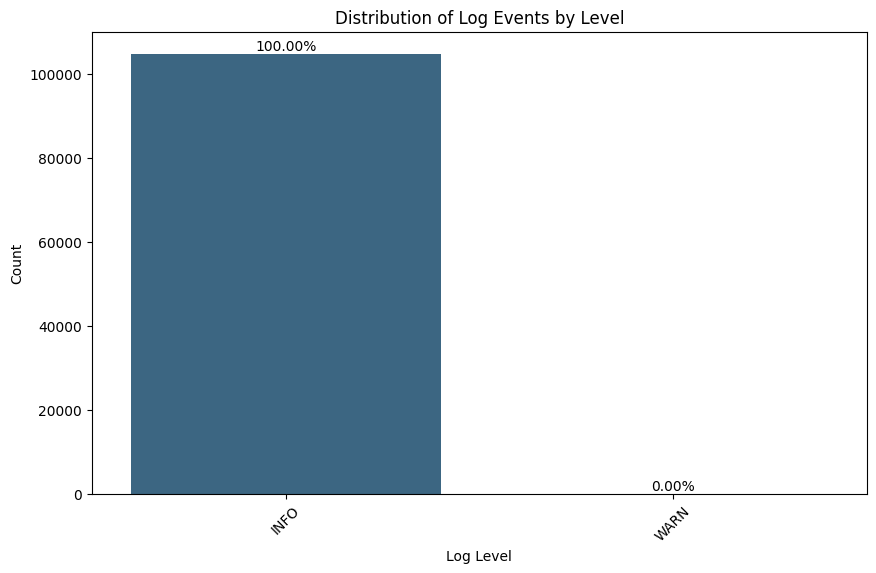

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=level_counts.index, y=level_counts.values, palette="viridis")
plt.title("Distribution of Log Events by Level")
plt.xlabel("Log Level")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Add percentage labels
total_logs = len(df)
for i, count in enumerate(level_counts):
    percentage = (count / total_logs) * 100
    plt.text(i, count, f"{percentage:.2f}%", ha='center', va='bottom')

plt.show()


In [116]:
# Convert the "Time" column to "HH:MM:SS" format
df['Time'] = df['Time'].apply(lambda x: f"{x // 10000:02d}:{(x // 100) % 100:02d}:{x % 100:02d}")


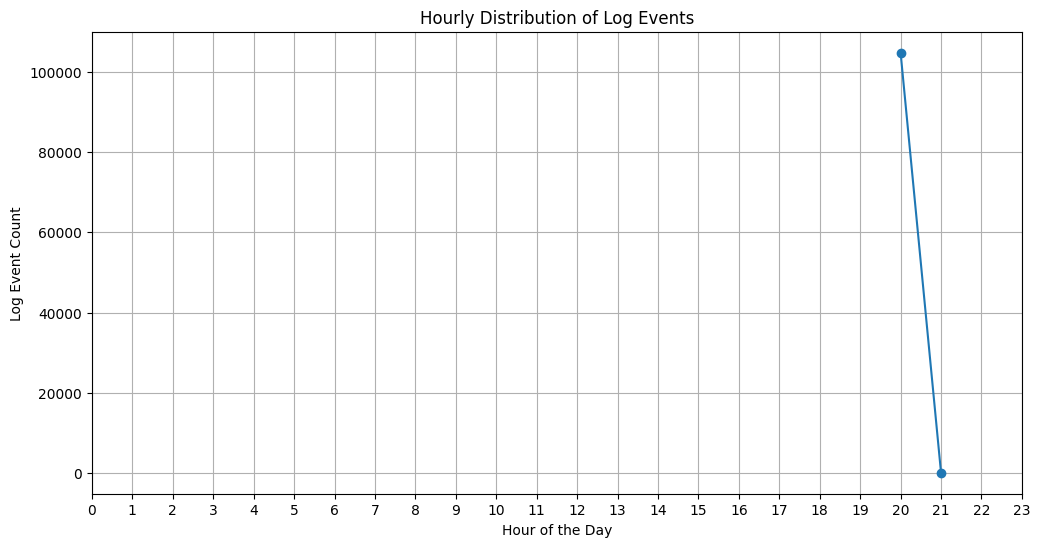

In [117]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'Time' column is already in datetime format
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S')

# Create a new column to extract the hour
df['Hour'] = df['Time'].dt.hour

# Group the data by the 'Hour' column and count log events in each hour
hourly_counts = df['Hour'].value_counts().sort_index()

# Create a line plot to visualize hourly log event patterns
plt.figure(figsize=(12, 6))
plt.plot(hourly_counts.index, hourly_counts.values, marker='o', linestyle='-')
plt.title('Hourly Distribution of Log Events')
plt.xlabel('Hour of the Day')
plt.ylabel('Log Event Count')
plt.grid(True)
plt.xticks(range(24))
plt.show()


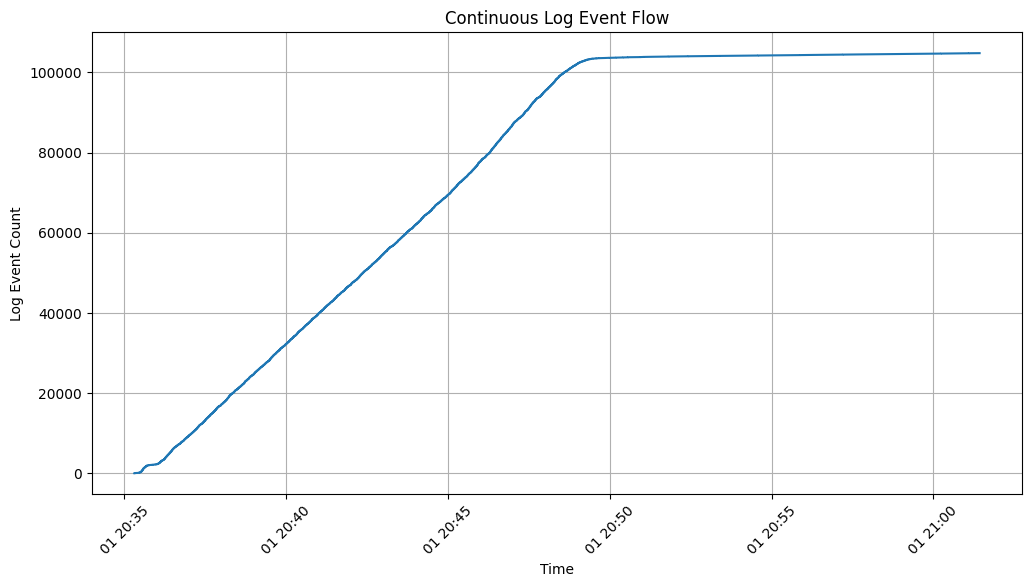

In [118]:


# Sort the DataFrame by the 'Time' column to ensure continuity
df = df.sort_values(by='Time')

# Create a line plot to visualize continuous log events
plt.figure(figsize=(12, 6))
plt.plot(df['Time'], range(len(df)), linestyle='-')
plt.title('Continuous Log Event Flow')
plt.xlabel('Time')
plt.ylabel('Log Event Count')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


# Convert the "Time" column to timestamps
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').apply(lambda x: x.timestamp())


In [119]:
df.head()

,Time,Pid,Level,Component,Content,EventId,EventTemplate,Classification,Hour
0,1900-01-01 20:35:18,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>,Not Malicious,20
1,1900-01-01 20:35:18,35,INFO,dfs.FSNamesystem,BLOCK* NameSystem.allocateBlock: /mnt/hadoop/m...,E22,BLOCK* NameSystem.allocateBlock:<*>,Not Malicious,20
11,1900-01-01 20:35:19,30,INFO,dfs.FSNamesystem,BLOCK* NameSystem.addStoredBlock: blockMap upd...,E26,BLOCK* NameSystem.addStoredBlock: blockMap upd...,Not Malicious,20
10,1900-01-01 20:35:19,29,INFO,dfs.FSNamesystem,BLOCK* NameSystem.addStoredBlock: blockMap upd...,E26,BLOCK* NameSystem.addStoredBlock: blockMap upd...,Not Malicious,20
9,1900-01-01 20:35:19,147,INFO,dfs.DataNode$PacketResponder,Received block blk_-1608999687919862906 of siz...,E9,Received block <*> of size <*> from /<*>,Not Malicious,20


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104815 entries, 0 to 104814
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Time            104815 non-null  datetime64[ns]
 1   Pid             104815 non-null  int64         
 2   Level           104815 non-null  object        
 3   Component       104815 non-null  object        
 4   Content         104815 non-null  object        
 5   EventId         104815 non-null  object        
 6   EventTemplate   104815 non-null  object        
 7   Classification  104815 non-null  object        
 8   Hour            104815 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int64(1), object(6)
memory usage: 7.6+ MB


In [121]:
# Count the number of occurrences of each classification
classification_counts = df['Classification'].value_counts()

# Print the number and percentage of each classification
total_samples = len(df)  # Total number of samples in the DataFrame

for classification, count in classification_counts.items():
    percentage = (count / total_samples) * 100
    print(f'Classification: {classification}, Count: {count}, Percentage: {percentage:.2f}%')

Classification: Not Malicious, Count: 81280, Percentage: 77.55%
Classification: Malicious, Count: 23535, Percentage: 22.45%


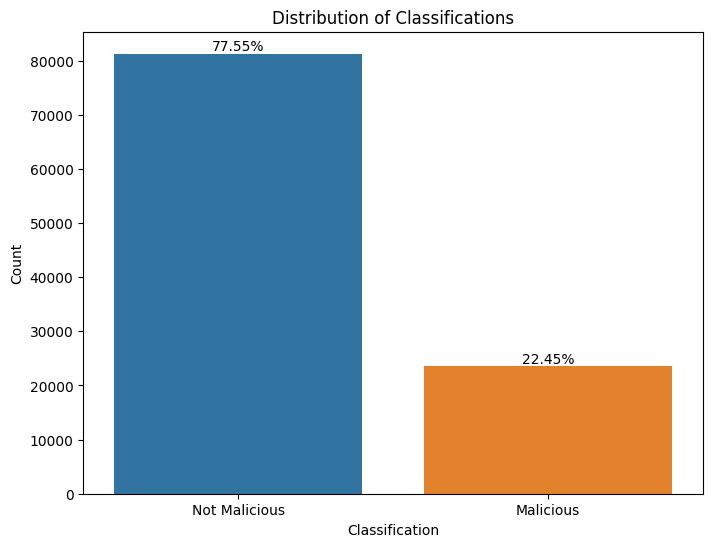

In [122]:




# Create a bar plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=classification_counts.index, y=classification_counts.values)
plt.title('Distribution of Classifications')
plt.xlabel('Classification')
plt.ylabel('Count')

# Add percentage labels
total_logs = len(df)
for p in ax.patches:
    percentage = 100 * p.get_height() / total_logs
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom')

# Show the plot
plt.show()


In [123]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 104815 entries, 0 to 104814
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Time            104815 non-null  datetime64[ns]
 1   Pid             104815 non-null  int64         
 2   Level           104815 non-null  object        
 3   Component       104815 non-null  object        
 4   Content         104815 non-null  object        
 5   EventId         104815 non-null  object        
 6   EventTemplate   104815 non-null  object        
 7   Classification  104815 non-null  object        
 8   Hour            104815 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int64(1), object(6)
memory usage: 7.6+ MB


,Time,Pid,Level,Component,Content,EventId,EventTemplate,Classification,Hour
0,1900-01-01 20:35:18,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>,Not Malicious,20
1,1900-01-01 20:35:18,35,INFO,dfs.FSNamesystem,BLOCK* NameSystem.allocateBlock: /mnt/hadoop/m...,E22,BLOCK* NameSystem.allocateBlock:<*>,Not Malicious,20
11,1900-01-01 20:35:19,30,INFO,dfs.FSNamesystem,BLOCK* NameSystem.addStoredBlock: blockMap upd...,E26,BLOCK* NameSystem.addStoredBlock: blockMap upd...,Not Malicious,20
10,1900-01-01 20:35:19,29,INFO,dfs.FSNamesystem,BLOCK* NameSystem.addStoredBlock: blockMap upd...,E26,BLOCK* NameSystem.addStoredBlock: blockMap upd...,Not Malicious,20
9,1900-01-01 20:35:19,147,INFO,dfs.DataNode$PacketResponder,Received block blk_-1608999687919862906 of siz...,E9,Received block <*> of size <*> from /<*>,Not Malicious,20


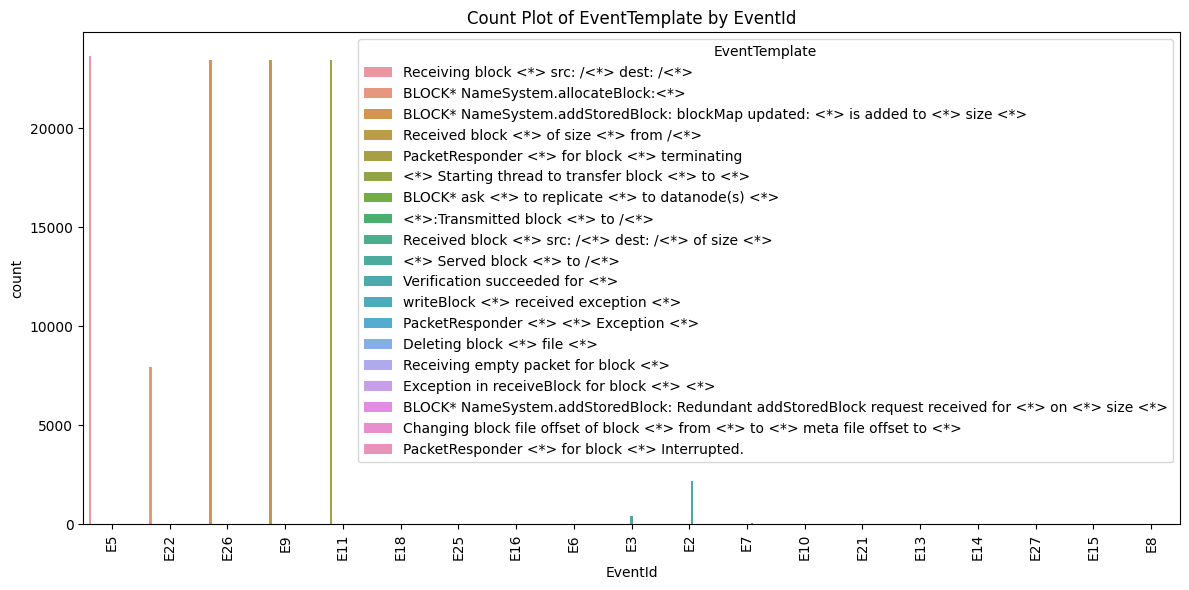

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a count plot to explore the relationship between 'EventId' and 'EventTemplate'
plt.figure(figsize=(12, 6))
sns.countplot(x='EventId', hue='EventTemplate', data=df)
plt.title('Count Plot of EventTemplate by EventId')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


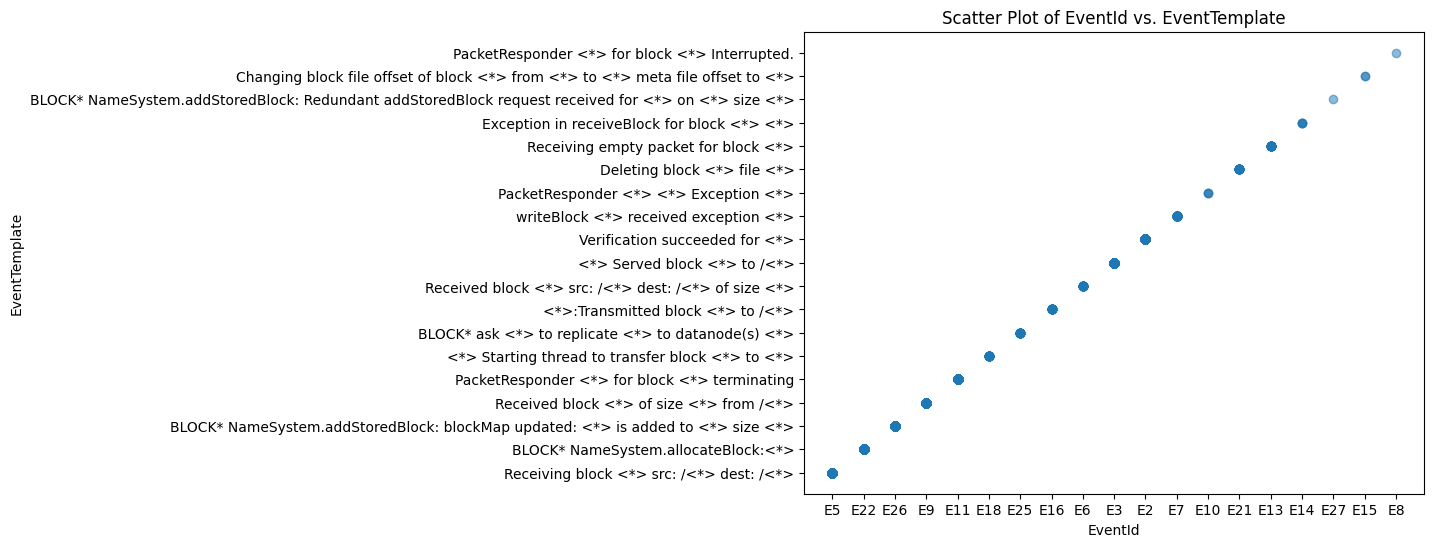

In [125]:
import matplotlib.pyplot as plt

# Scatter plot between 'EventId' and 'EventTemplate'
plt.figure(figsize=(8, 6))
plt.scatter(df['EventId'], df['EventTemplate'], alpha=0.5)
plt.title('Scatter Plot of EventId vs. EventTemplate')
plt.xlabel('EventId')
plt.ylabel('EventTemplate')
plt.show()




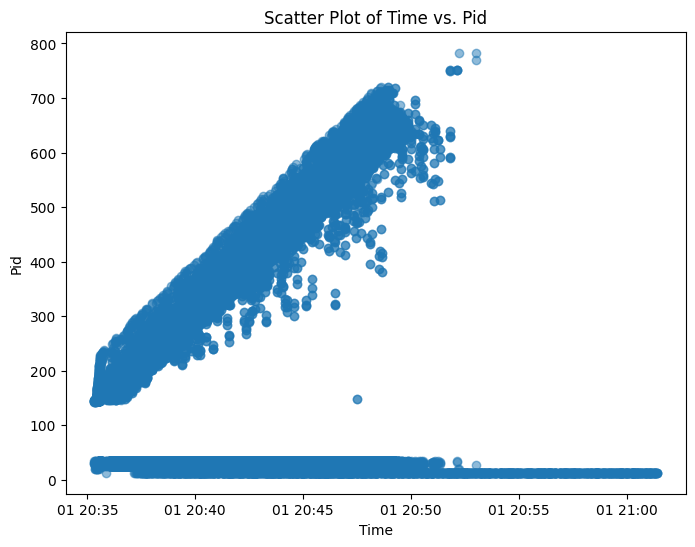

In [126]:
# Scatter plot between 'Time' and 'Pid'
plt.figure(figsize=(8, 6))
plt.scatter(df['Time'], df['Pid'], alpha=0.5)
plt.title('Scatter Plot of Time vs. Pid')
plt.xlabel('Time')
plt.ylabel('Pid')
plt.show()

# You can create additional scatter plots for other pairs of columns as needed


In [127]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
label_encoder = LabelEncoder()

# List of categorical columns to encode
categorical_columns = ['Level', 'Component',"Content", 'EventId', 'EventTemplate',"Classification"]

# Apply label encoding to each categorical column
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])

# Now, the categorical columns are encoded with numerical values


In [128]:

df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 104815 entries, 0 to 104814
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Time            104815 non-null  datetime64[ns]
 1   Pid             104815 non-null  int64         
 2   Level           104815 non-null  int64         
 3   Component       104815 non-null  int64         
 4   Content         104815 non-null  int64         
 5   EventId         104815 non-null  int64         
 6   EventTemplate   104815 non-null  int64         
 7   Classification  104815 non-null  int64         
 8   Hour            104815 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int64(7)
memory usage: 7.6 MB


,Time,Pid,Level,Component,Content,EventId,EventTemplate,Classification,Hour
0,1900-01-01 20:35:18,143,0,4,71845,14,15,1,20
1,1900-01-01 20:35:18,35,0,7,23940,9,5,1,20
11,1900-01-01 20:35:19,30,0,7,6798,11,4,1,20
10,1900-01-01 20:35:19,29,0,7,1049,11,4,1,20
9,1900-01-01 20:35:19,147,0,5,55910,18,13,1,20
8,1900-01-01 20:35:19,147,0,5,32194,1,12,0,20
7,1900-01-01 20:35:19,145,0,5,55911,18,13,1,20
12,1900-01-01 20:35:19,31,0,7,2102,11,4,1,20
5,1900-01-01 20:35:19,145,0,5,47827,1,12,0,20
4,1900-01-01 20:35:19,145,0,5,40011,1,12,0,20


In [129]:
from scipy import stats

# Calculate the Z-scores for each numerical column
z_scores = np.abs(stats.zscore(df.select_dtypes(include=['int64'])))

# Define a Z-score threshold
z_score_threshold = 3

# Identify rows with Z-scores exceeding the threshold
anomalies_z_score = (z_scores > z_score_threshold).any(axis=1)

# Filter the DataFrame to get the rows with anomalies
anomalies_df = df[anomalies_z_score]

anomalies_df
anomalies_z_score

0         False
1         False
11        False
10        False
9         False
          ...  
104809     True
104811     True
104813     True
104812     True
104814     True
Length: 104815, dtype: bool

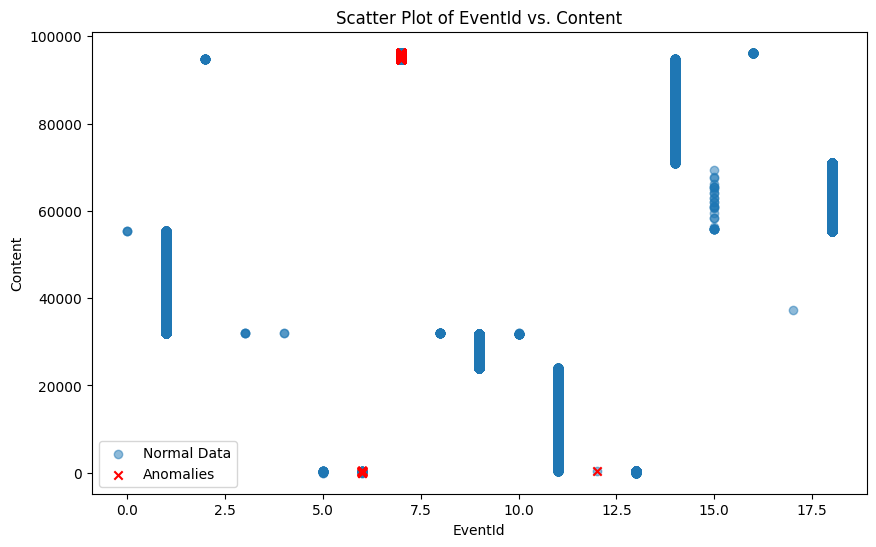

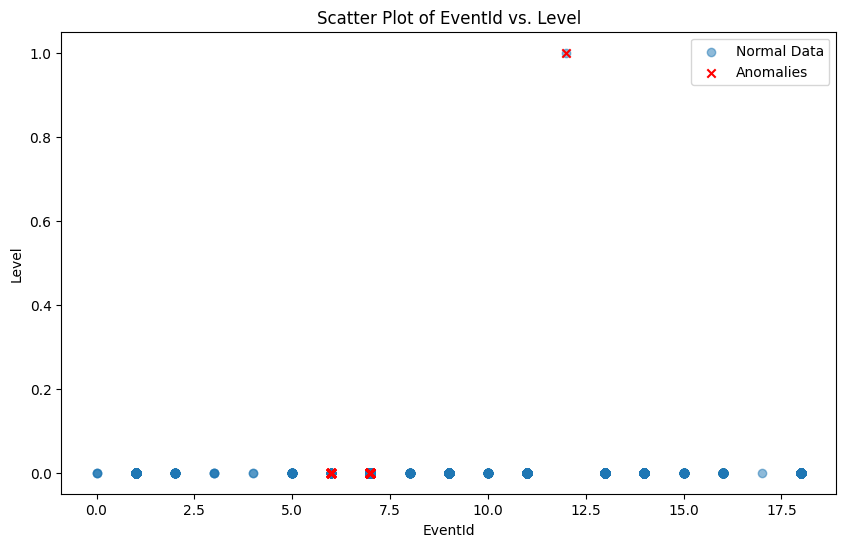

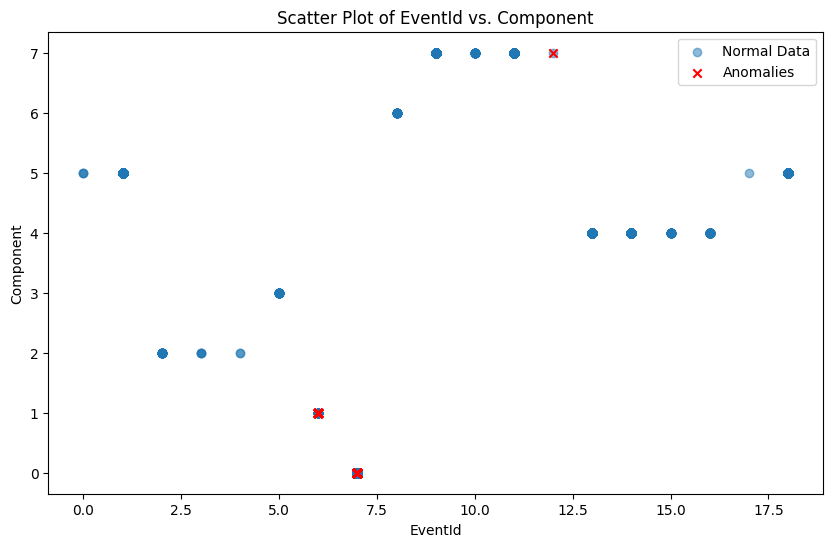

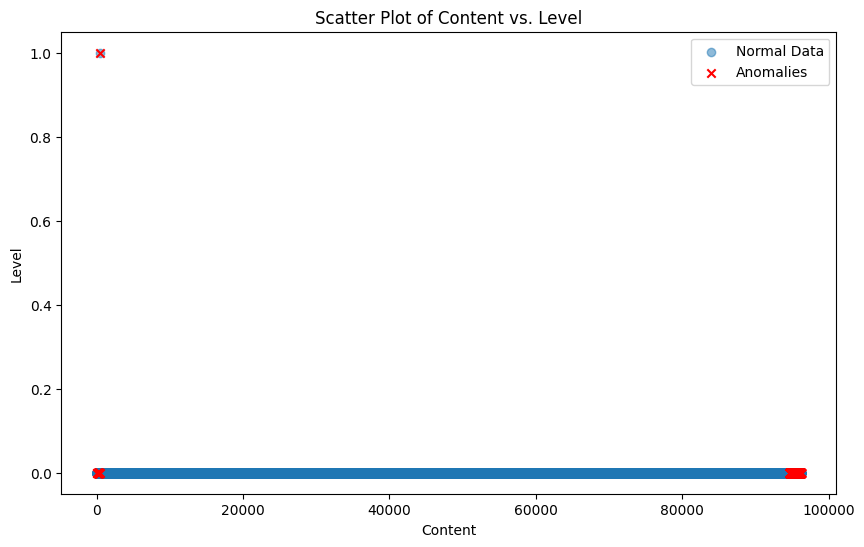

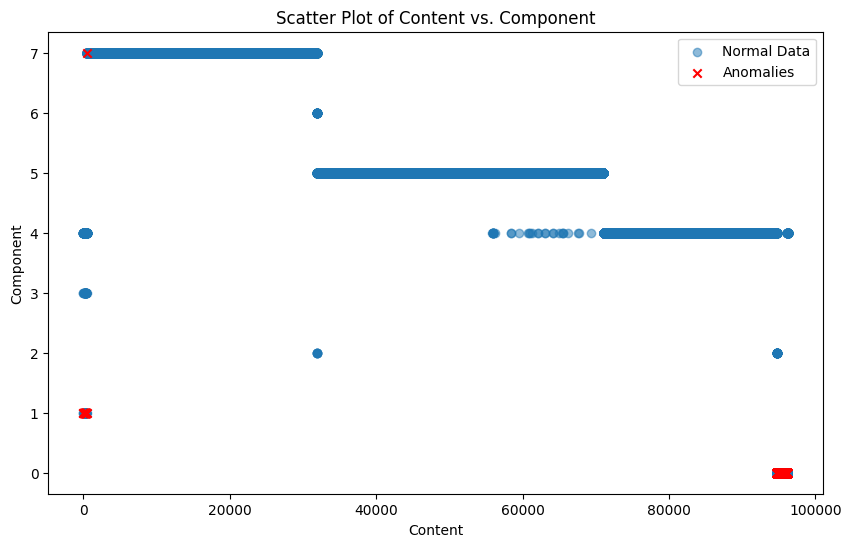

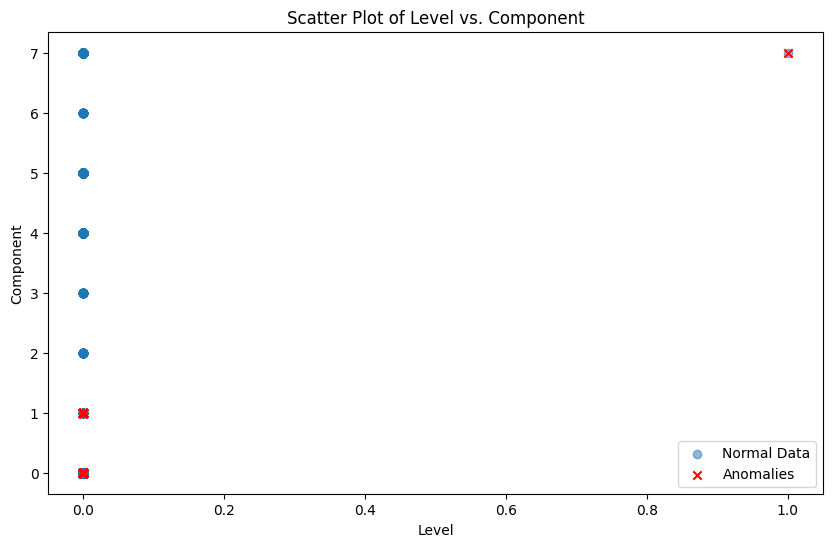

In [130]:
import matplotlib.pyplot as plt

# Define the numerical columns to visualize
numerical_columns = ['EventId', 'Content', 'Level', 'Component']

# Create scatter plots for each pair of columns
for i in range(len(numerical_columns)):
    for j in range(i + 1, len(numerical_columns)):
        column_x = numerical_columns[i]
        column_y = numerical_columns[j]
        
        plt.figure(figsize=(10, 6))
        plt.scatter(df[column_x], df[column_y], label='Normal Data', alpha=0.5)
        plt.scatter(anomalies_df[column_x], anomalies_df[column_y], c='red', marker='x', label='Anomalies')
        plt.xlabel(column_x)
        plt.ylabel(column_y)
        plt.legend()
        plt.title(f'Scatter Plot of {column_x} vs. {column_y}')
        plt.show()


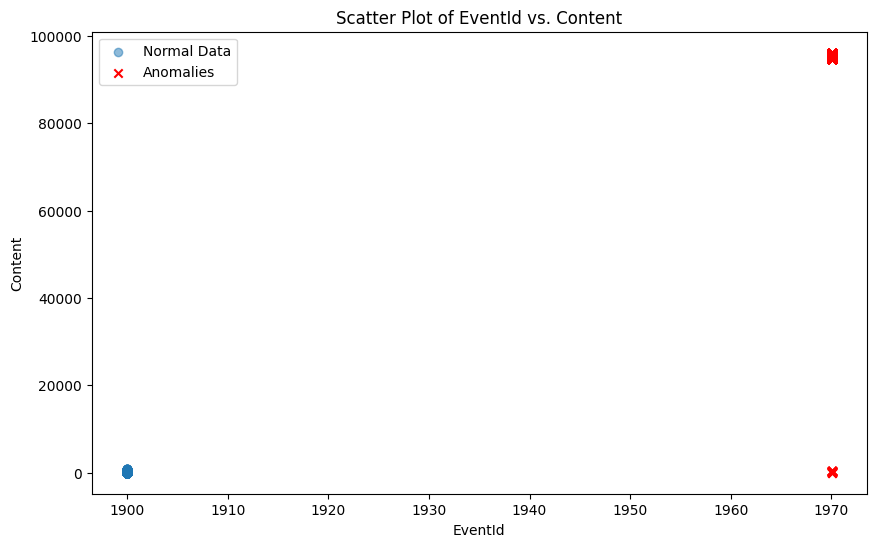

In [131]:
import matplotlib.pyplot as plt

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['Time'], df['Pid'], label='Normal Data', alpha=0.5)
plt.scatter(anomalies_df['EventId'], anomalies_df['Content'], c='red', marker='x', label='Anomalies')
plt.xlabel('EventId')
plt.ylabel('Content')
plt.legend()
plt.title('Scatter Plot of EventId vs. Content')
plt.show()


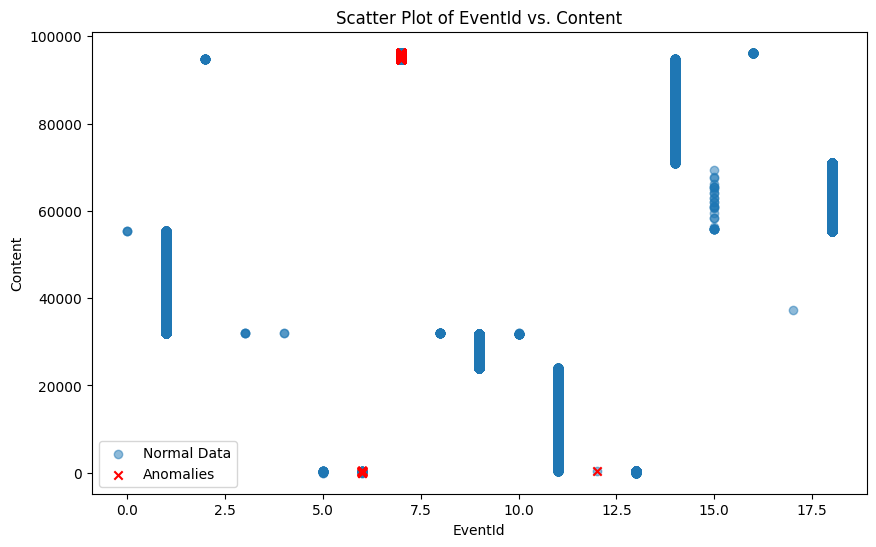

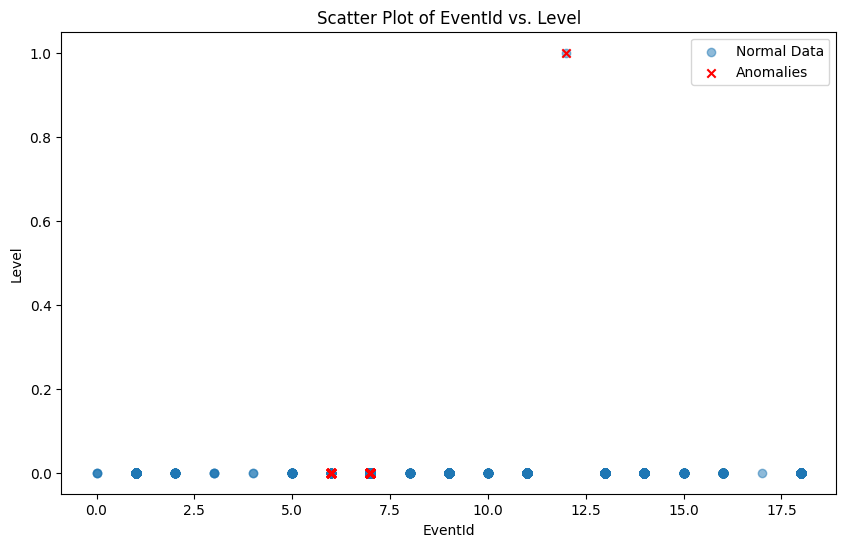

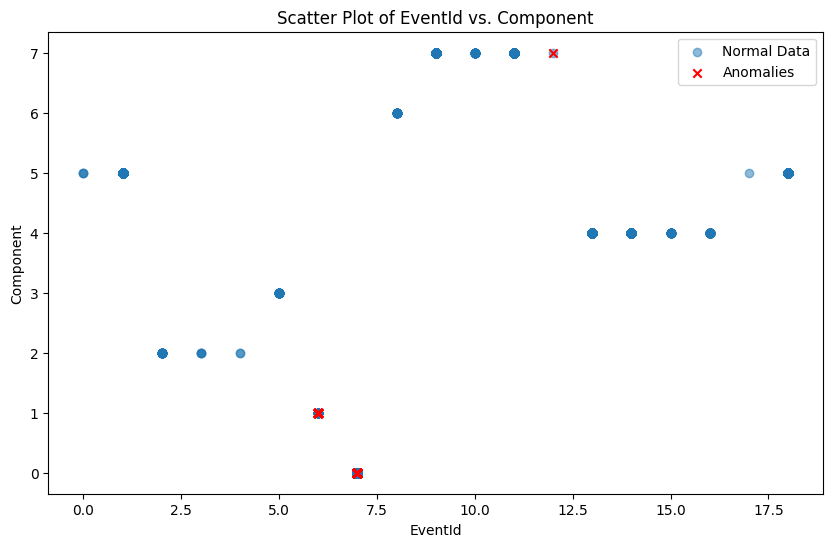

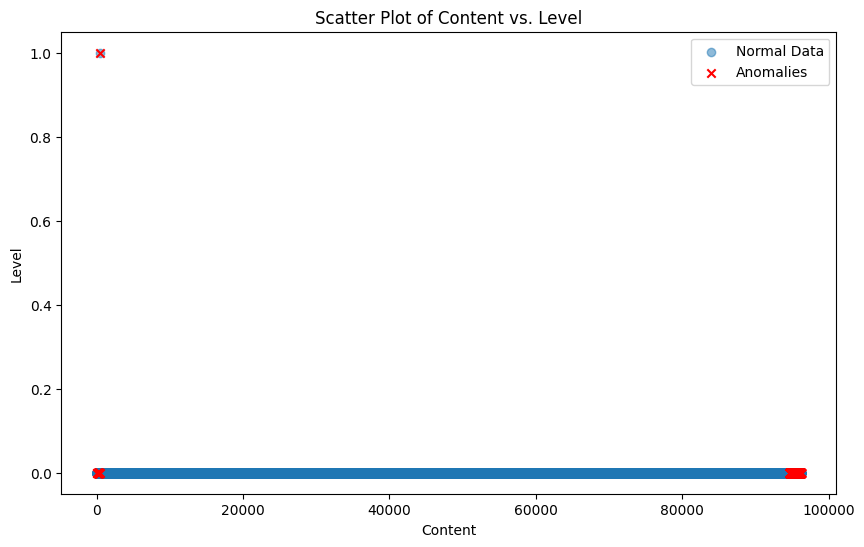

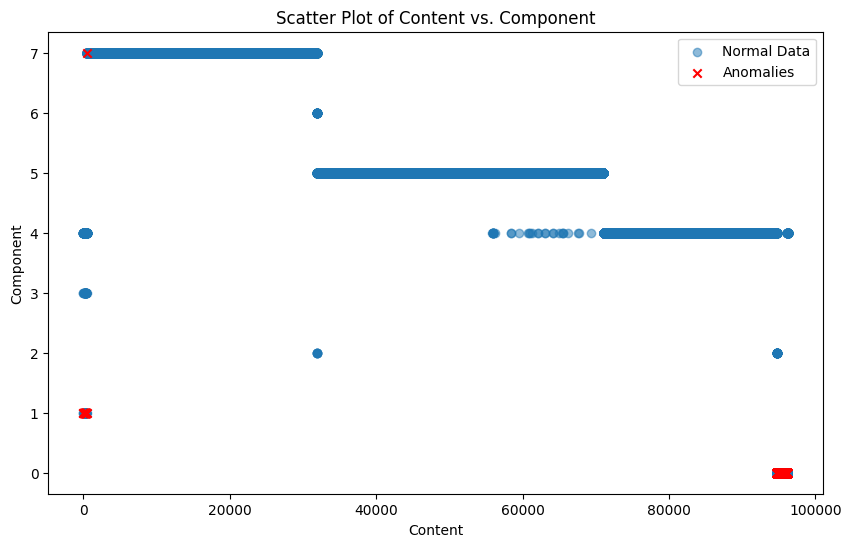

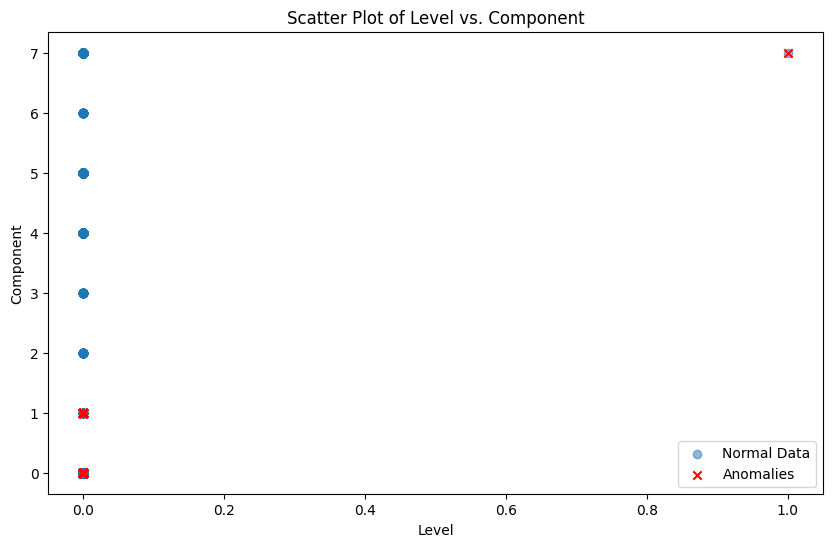

In [132]:
import matplotlib.pyplot as plt

# Define the numerical columns to visualize
numerical_columns = ['EventId', 'Content', 'Level', 'Component']

# Create scatter plots for each pair of columns
for i in range(len(numerical_columns)):
    for j in range(i + 1, len(numerical_columns)):
        column_x = numerical_columns[i]
        column_y = numerical_columns[j]
        
        plt.figure(figsize=(10, 6))
        plt.scatter(df[column_x], df[column_y], label='Normal Data', alpha=0.5)
        plt.scatter(anomalies_df[column_x], anomalies_df[column_y], c='red', marker='x', label='Anomalies')
        plt.xlabel(column_x)
        plt.ylabel(column_y)
        plt.legend()
        plt.title(f'Scatter Plot of {column_x} vs. {column_y}')
        plt.show()


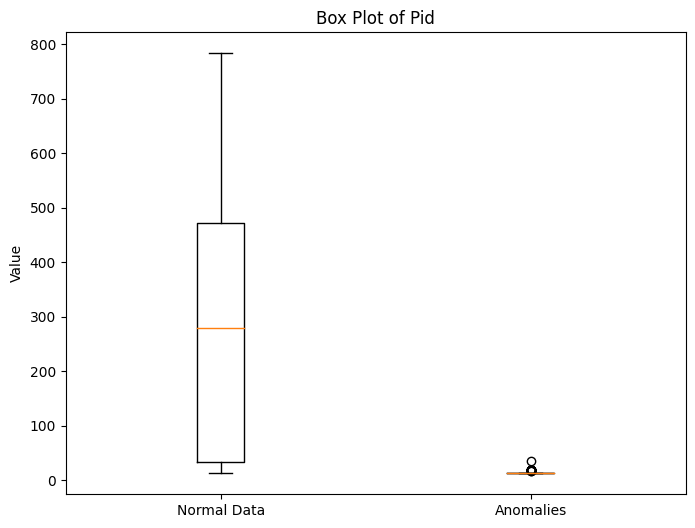

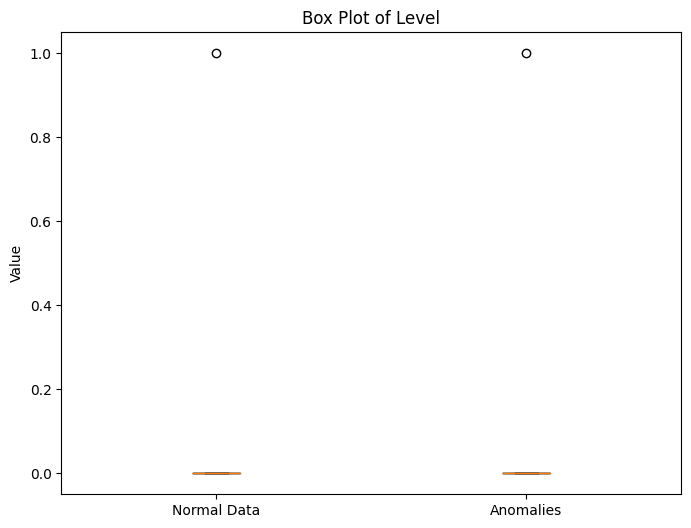

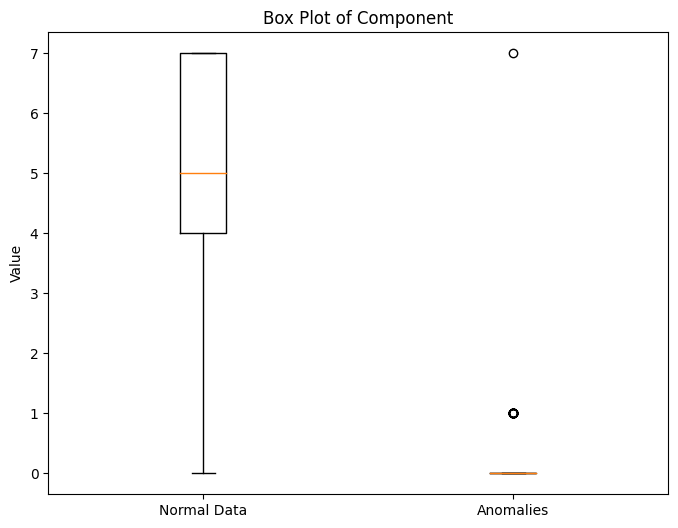

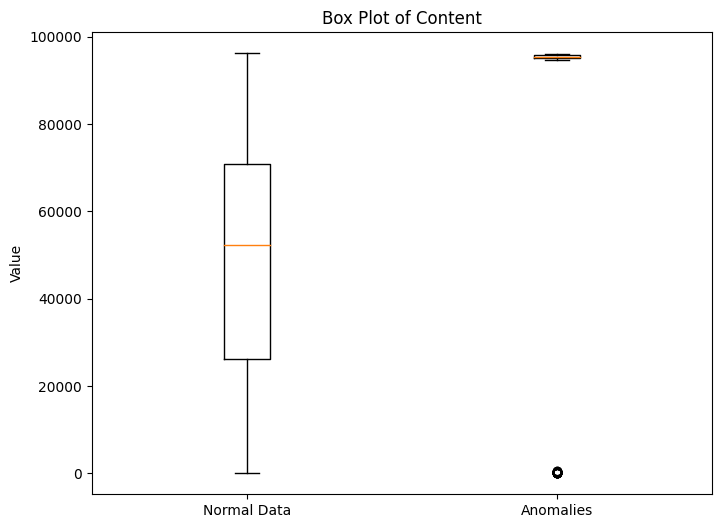

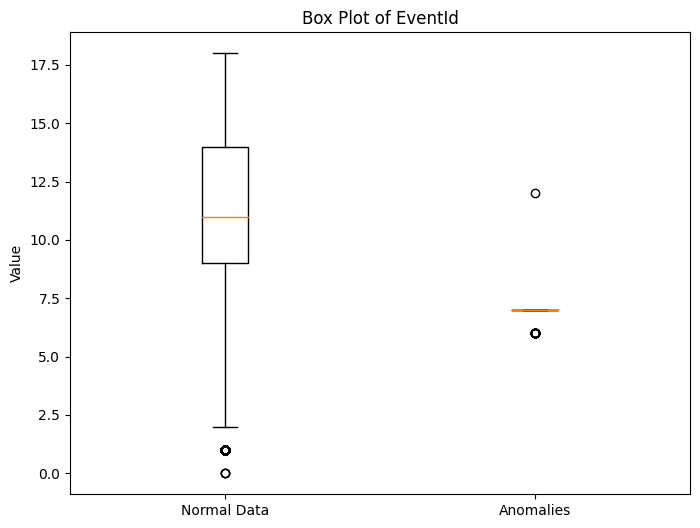

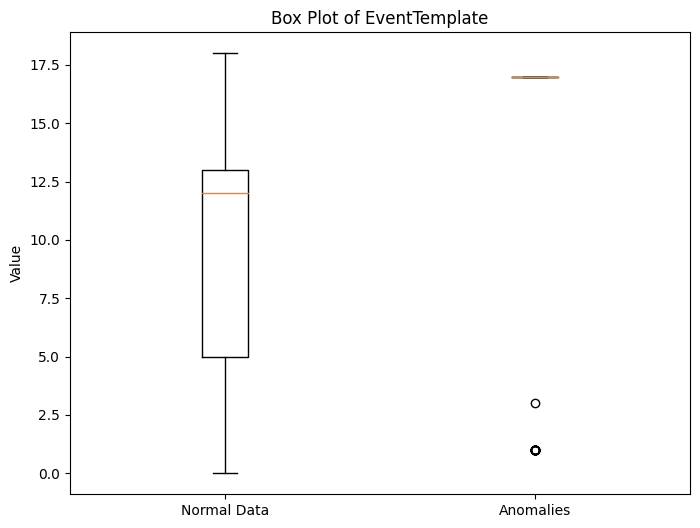

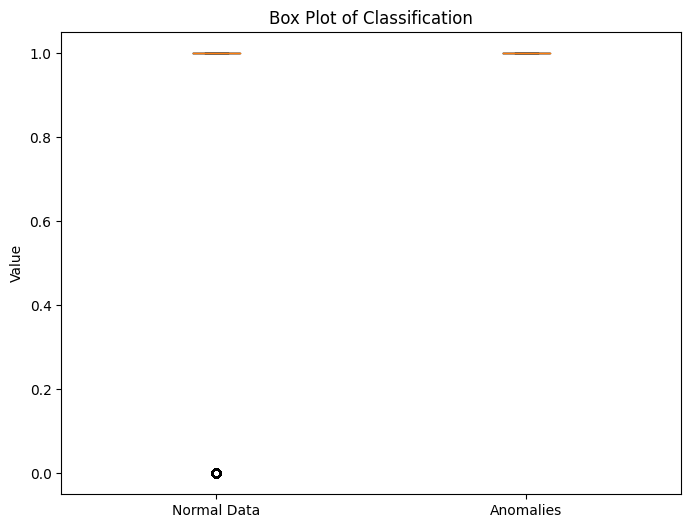

In [133]:
# Create box plots for numerical columns
for column in df.select_dtypes(include=['int64']).columns:
    plt.figure(figsize=(8, 6))
    plt.boxplot([df[column], anomalies_df[column]], labels=['Normal Data', 'Anomalies'])
    plt.title(f'Box Plot of {column}')
    plt.ylabel('Value')
    plt.show()


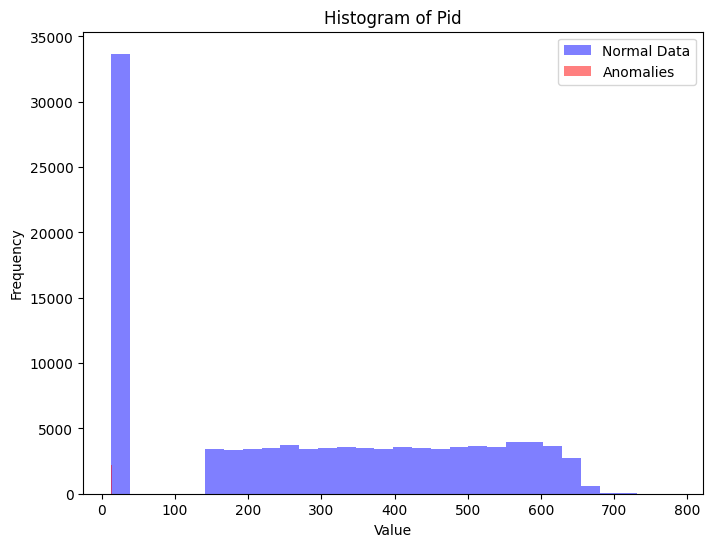

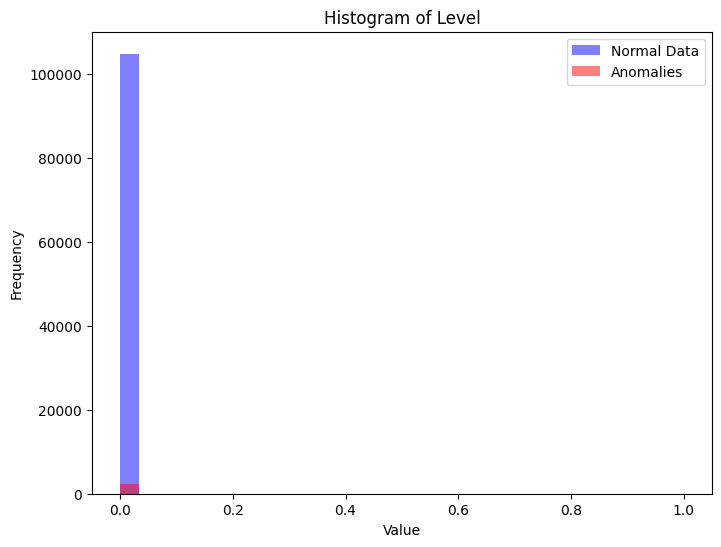

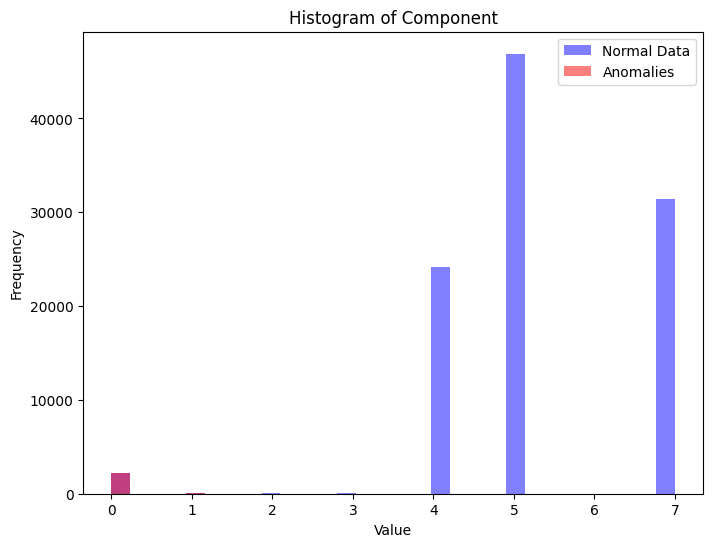

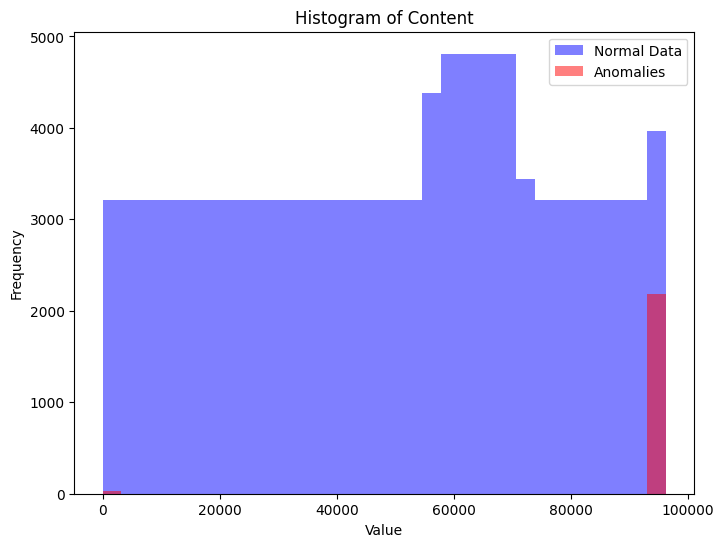

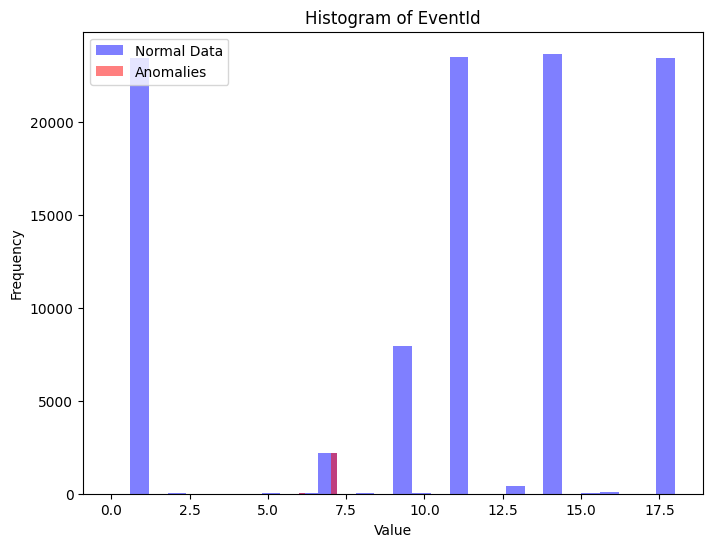

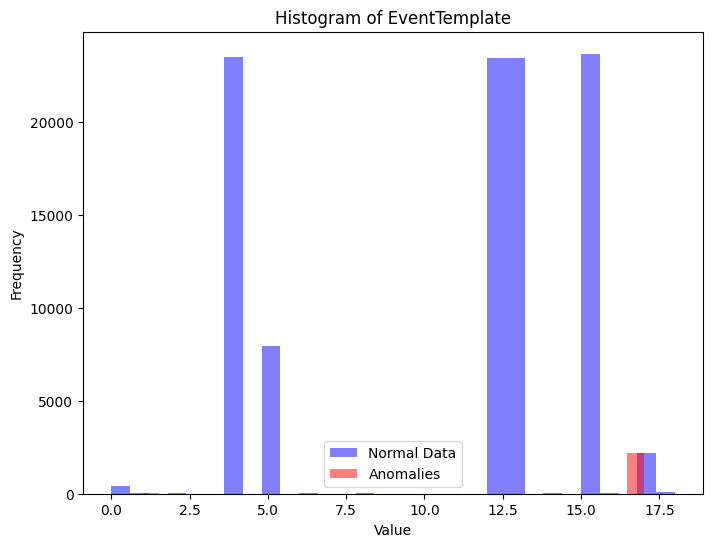

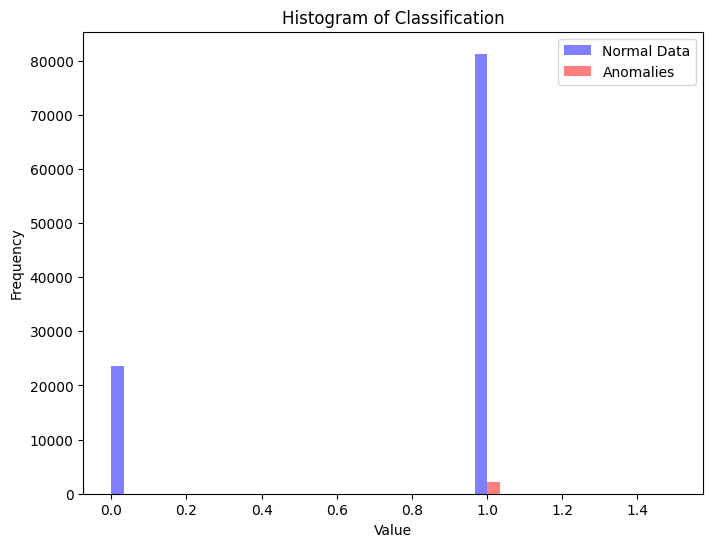

In [134]:
# Create histograms for numerical columns
for column in df.select_dtypes(include=['int64']).columns:
    plt.figure(figsize=(8, 6))
    plt.hist(df[column], bins=30, alpha=0.5, label='Normal Data', color='blue')
    plt.hist(anomalies_df[column], bins=30, alpha=0.5, label='Anomalies', color='red')
    plt.title(f'Histogram of {column}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


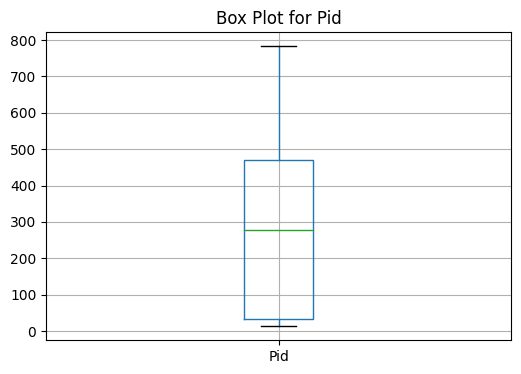

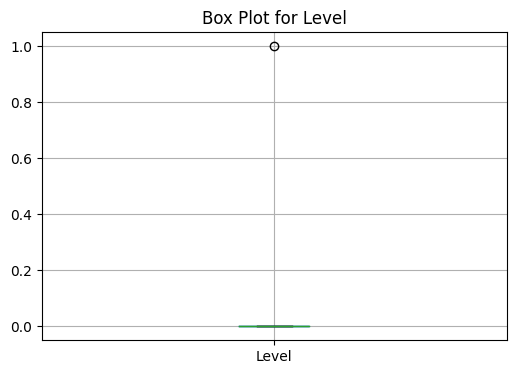

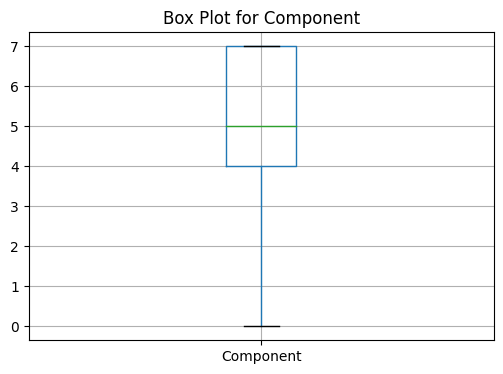

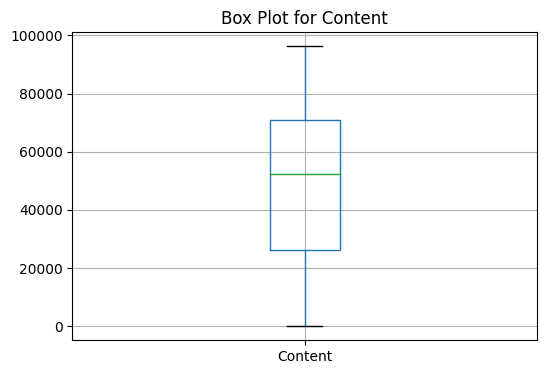

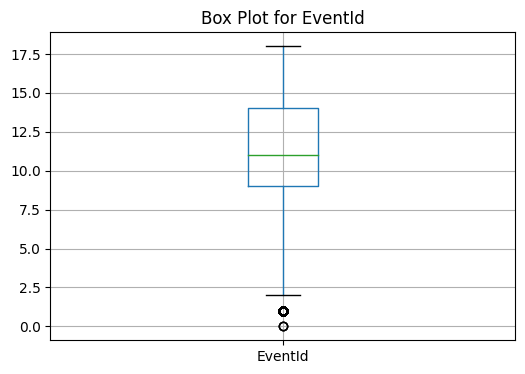

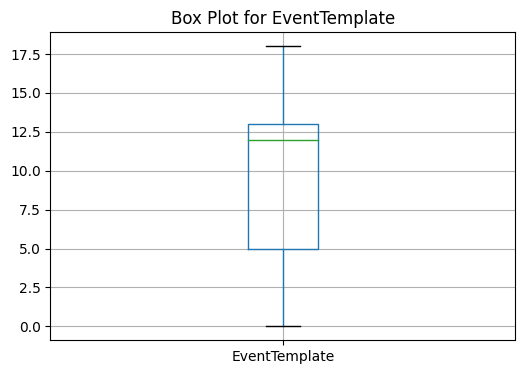

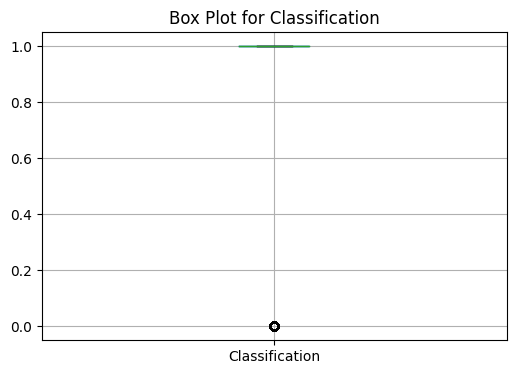

In [135]:
import matplotlib.pyplot as plt

# Iterate through columns and create box plots
for column in df.columns:
    if df[column].dtype in ['int64', 'float64']:
        plt.figure(figsize=(6, 4))
        df.boxplot(column=[column])
        plt.title(f'Box Plot for {column}')
        plt.show()


/tmp/ipykernel_32/1651563560.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[column_name], shade=True)


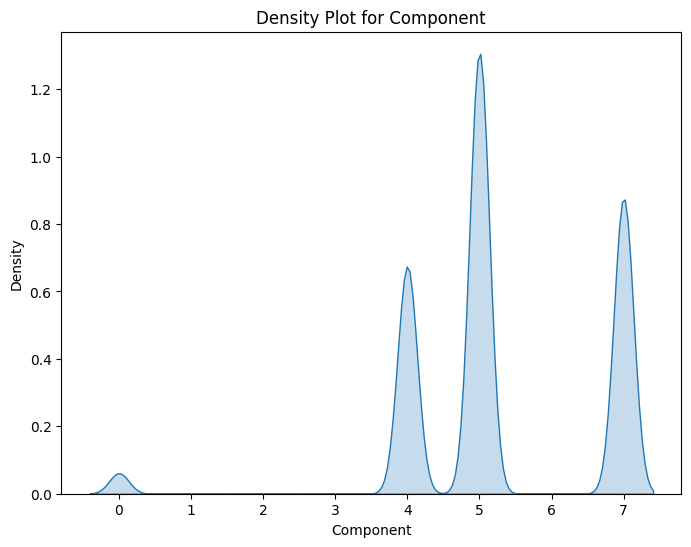

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt

# Replace 'your_column_name' with the name of the column you want to create a density plot for
column_name = 'Component'

# Create a density plot
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df[column_name], shade=True)
plt.title(f'Density Plot for {column_name}')
plt.xlabel(column_name)
plt.ylabel('Density')

# Show the plot
plt.show()


/tmp/ipykernel_32/4178211204.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[column_name], shade=True)


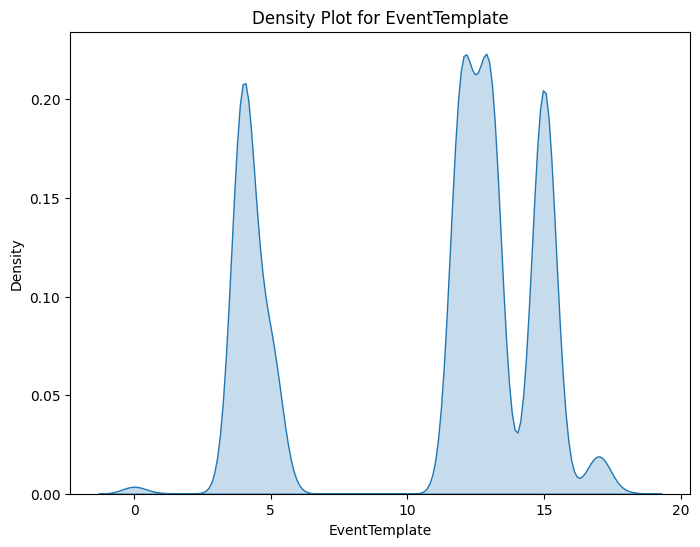

In [137]:
# Replace 'your_column_name' with the name of the column you want to create a density plot for
column_name = 'EventTemplate'

# Create a density plot
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df[column_name], shade=True)
plt.title(f'Density Plot for {column_name}')
plt.xlabel(column_name)
plt.ylabel('Density')

# Show the plot
plt.show()


/tmp/ipykernel_32/4269485369.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[column_name], shade=True)


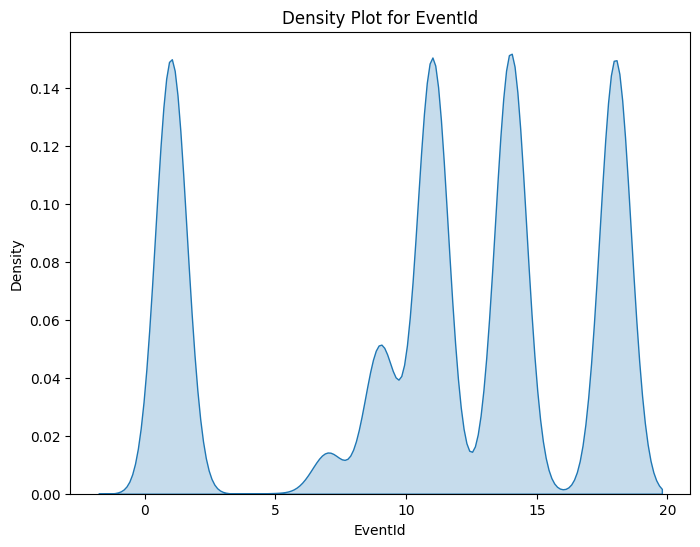

In [138]:
# Replace 'your_column_name' with the name of the column you want to create a density plot for
column_name = 'EventId'

# Create a density plot
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df[column_name], shade=True)
plt.title(f'Density Plot for {column_name}')
plt.xlabel(column_name)
plt.ylabel('Density')

# Show the plot
plt.show()


/tmp/ipykernel_32/3271692745.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[column_name], shade=True)


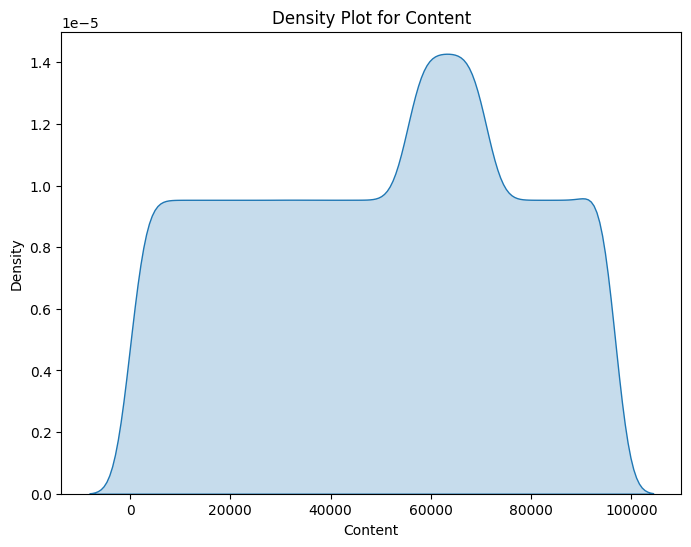

In [139]:
# Replace 'your_column_name' with the name of the column you want to create a density plot for
column_name = 'Content'

# Create a density plot
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df[column_name], shade=True)
plt.title(f'Density Plot for {column_name}')
plt.xlabel(column_name)
plt.ylabel('Density')

# Show the plot
plt.show()

In [140]:
df.corr()

,Time,Pid,Level,Component,Content,EventId,EventTemplate,Classification,Hour
Time,1.000000,0.396554,0.004973,-0.103167,0.036938,-0.039520,0.043129,-0.012747,0.151738
Pid,0.396554,1.000000,-0.003588,-0.512856,0.589128,0.047006,0.712707,-0.304794,-0.043712
Level,0.004973,-0.003588,1.000000,0.003902,-0.005573,0.000629,-0.005324,0.001662,-0.000107
Component,-0.103167,-0.512856,0.003902,1.000000,-0.858552,-0.060936,-0.891893,0.103171,-0.132279
Content,0.036938,0.589128,-0.005573,-0.858552,1.000000,0.345656,0.926506,0.116679,0.058231
EventId,-0.039520,0.047006,0.000629,-0.060936,0.345656,1.000000,0.146458,0.874682,-0.021741
EventTemplate,0.043129,0.712707,-0.005324,-0.891893,0.926506,0.146458,1.000000,-0.165029,0.049668
Classification,-0.012747,-0.304794,0.001662,0.103171,0.116679,0.874682,-0.165029,1.000000,0.018594
Hour,0.151738,-0.043712,-0.000107,-0.132279,0.058231,-0.021741,0.049668,0.018594,1.000000


In [141]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 104815 entries, 0 to 104814
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Time            104815 non-null  datetime64[ns]
 1   Pid             104815 non-null  int64         
 2   Level           104815 non-null  int64         
 3   Component       104815 non-null  int64         
 4   Content         104815 non-null  int64         
 5   EventId         104815 non-null  int64         
 6   EventTemplate   104815 non-null  int64         
 7   Classification  104815 non-null  int64         
 8   Hour            104815 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int64(7)
memory usage: 7.6 MB


,Time,Pid,Level,Component,Content,EventId,EventTemplate,Classification,Hour
0,1900-01-01 20:35:18,143,0,4,71845,14,15,1,20
1,1900-01-01 20:35:18,35,0,7,23940,9,5,1,20
11,1900-01-01 20:35:19,30,0,7,6798,11,4,1,20
10,1900-01-01 20:35:19,29,0,7,1049,11,4,1,20
9,1900-01-01 20:35:19,147,0,5,55910,18,13,1,20


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


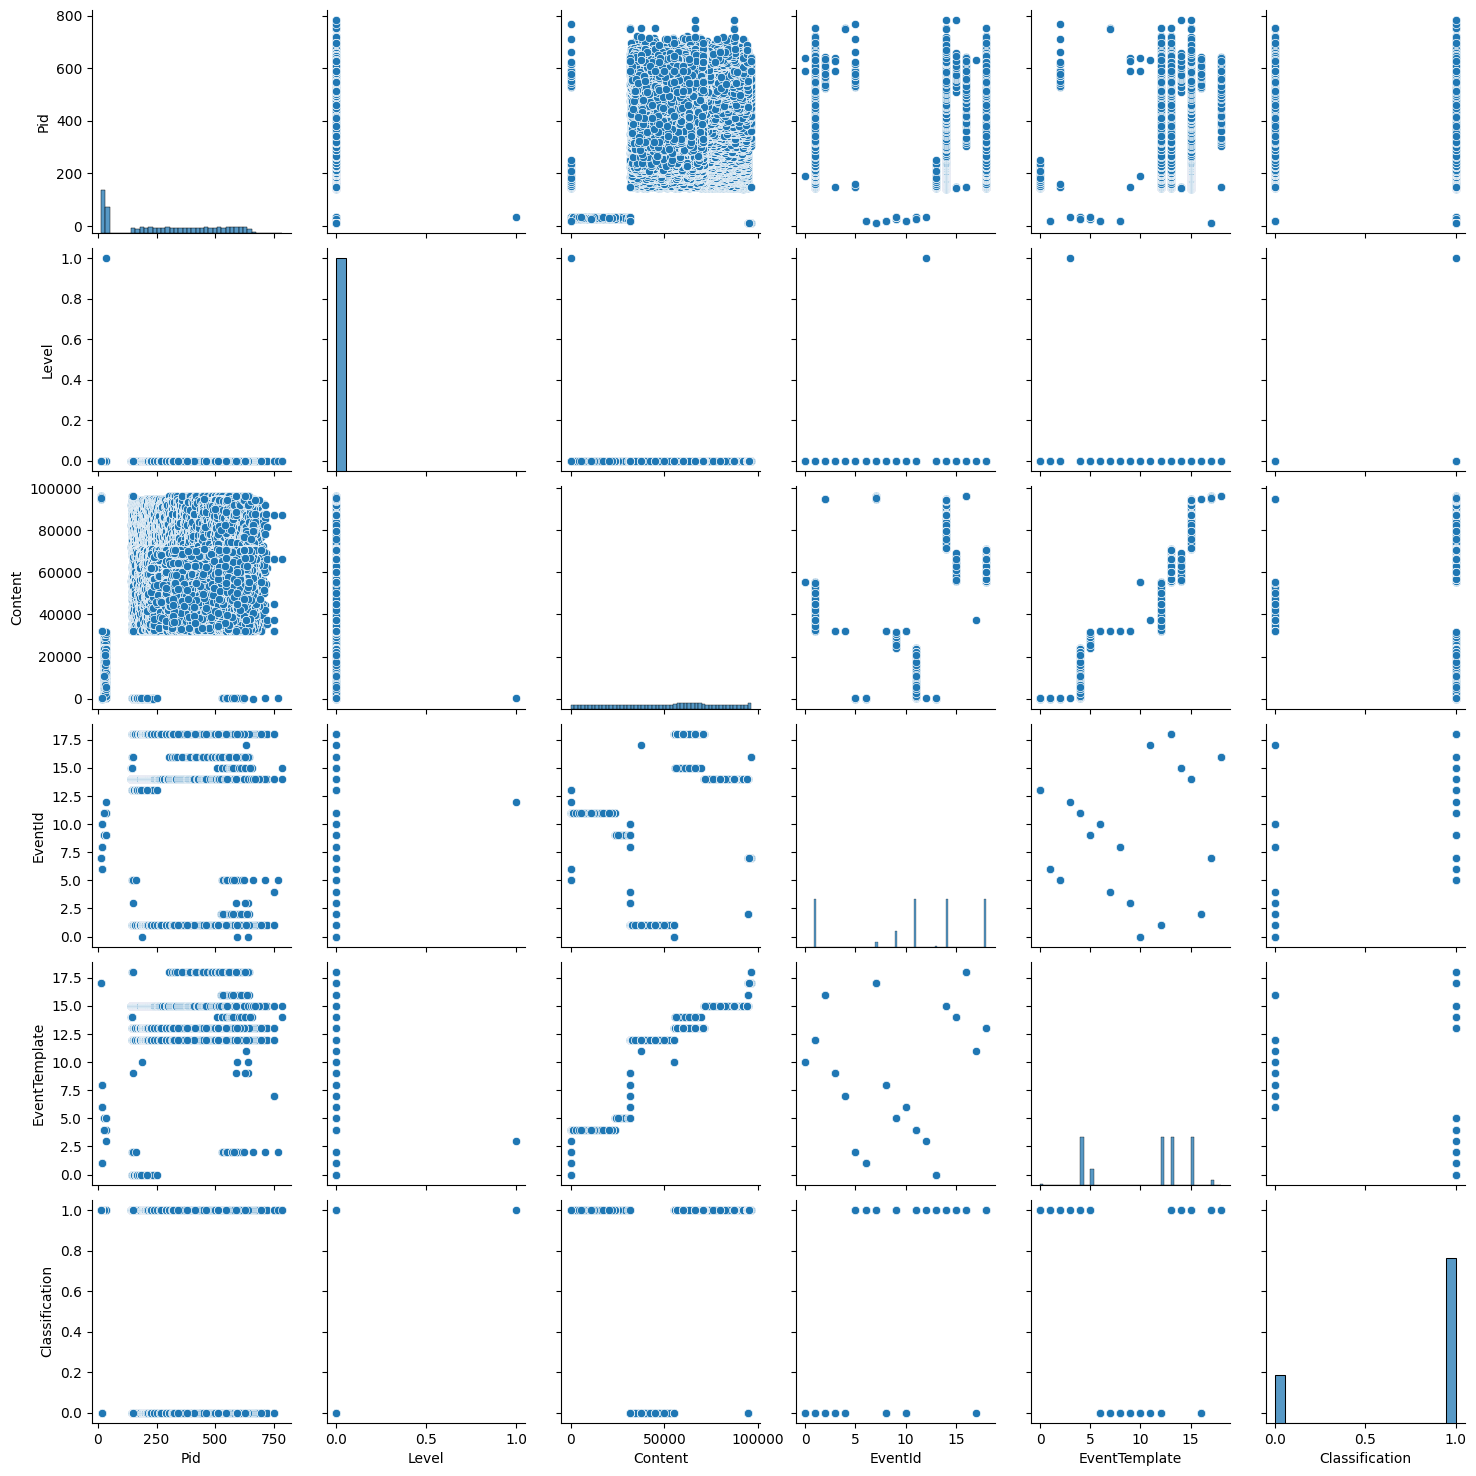

In [142]:
import seaborn as sns

# Create a scatter plot matrix for selected columns
columns_to_plot = ['Time', 'Pid', 'Level', 'Content', 'EventId', 'EventTemplate', 'Classification']
scatter_matrix = sns.pairplot(df[columns_to_plot])
plt.show()

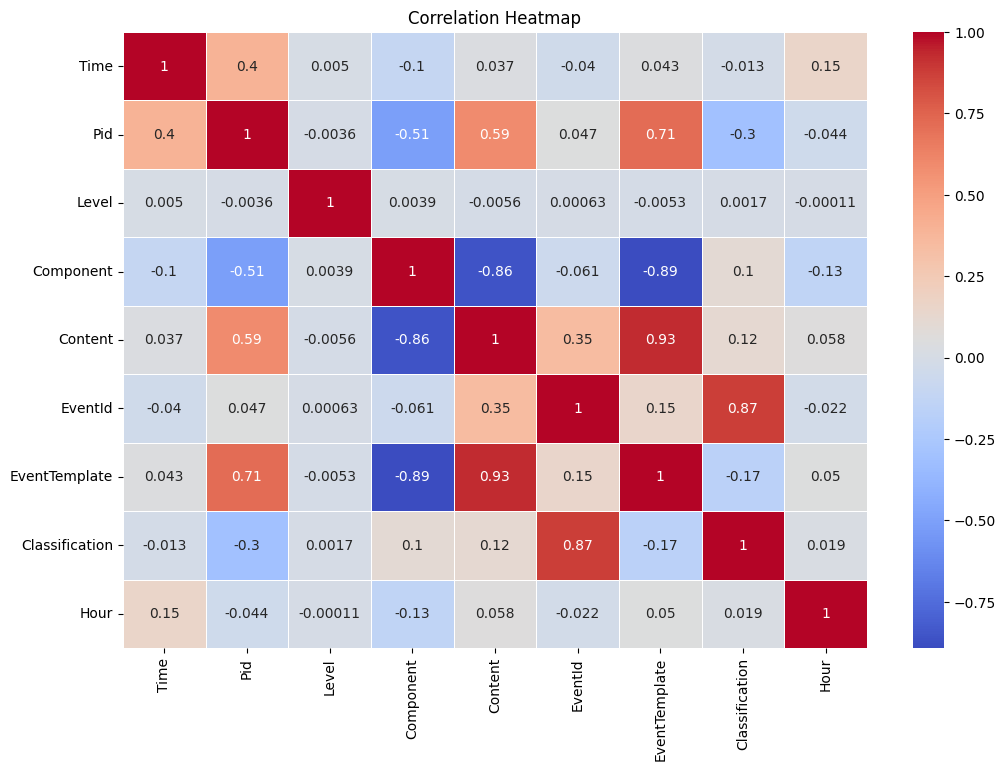

In [143]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


In [144]:
import pandas as pd
from scipy.stats import chi2_contingency

# Assuming you have a DataFrame df with the necessary columns
crosstab = pd.crosstab(df['Classification'], df['EventTemplate'])  # Replace 'Level' with the column you want to test

# Perform the chi-squared test
chi2, p, dof, expected = chi2_contingency(crosstab)

print(f"Chi-squared value: {chi2}")
print(f"P-value: {p}")
print(f'Degrees of Freedom: {dof}')


Chi-squared value: 104815.0
P-value: 0.0
Degrees of Freedom: 18


In [145]:
from sklearn.ensemble import IsolationForest

# Select the numerical columns for anomaly detection
numerical_columns = ['EventId', 'Content', 'Level', 'Component']
X = df[numerical_columns]

# Initialize the Isolation Forest model
clf = IsolationForest(contamination=0.05)  # Adjust the contamination parameter as needed

# Fit the model to your data
clf.fit(X)

# Predict anomalies (outliers)
anomaly_predictions = clf.predict(X)

# Create a DataFrame containing the anomaly predictions
anomalies_df = df.copy()
anomalies_df['IsolationForestAnomaly'] = anomaly_predictions

# Filter the rows where IsolationForestAnomaly is labeled as -1 (anomaly)
anomalies_df = anomalies_df[anomalies_df['IsolationForestAnomaly'] == -1]

# Visualize these anomalies using scatter plots or other relevant visualizations

# For additional anomaly detection methods, you can follow a similar process with One-Class SVM or other techniques.


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [146]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers



# Split the dataset into features (X) and target (y)
X = df.drop(columns=['Classification',"Time", "EventTemplate"])  # Features
y = df['Classification']  # Target



In [147]:
from imblearn.over_sampling import RandomOverSampler

from sklearn.preprocessing import StandardScaler
# Define the oversampler
oversampler = RandomOverSampler(random_state=42)

# Resample the dataset to balance the classes
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Split the resampled data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
# Standardize the features for the resampled data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

**DNN MODEL**

In [148]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Define a function to create the DNN model
def create_dnn_model(hidden_units=64, activation='relu', optimizer='adam'):
    model = keras.Sequential()
    model.add(layers.Dense(hidden_units, activation=activation, input_dim=X_train.shape[1]))
    model.add(layers.Dense(32, activation=activation))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create a KerasClassifier with your model function
model = KerasClassifier(build_fn=create_dnn_model, verbose=0)

# Define hyperparameters to search
param_grid = {
    'hidden_units': [64, 128],  # You can add more options
    'activation': ['relu', 'tanh'],
    'optimizer': ['adam', 'sgd']
}

# Create a GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)

# Fit the grid search to your data
grid_result = grid.fit(X_train, y_train)

# Get the best parameters and their associated accuracy
best_params = grid_result.best_params_
best_accuracy = grid_result.best_score_

print("Best Hyperparameters: ", best_params)
print("Best Accuracy: {:.2f}%".format(best_accuracy * 100))


/tmp/ipykernel_32/1680452658.py:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_dnn_model, verbose=0)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
1186/1186 [==============================] - 1s 1ms/step
Best Hyperparameters:  {'activation': 'relu', 'hidden_units': 128, 'optimizer': 'adam'}
Best Accuracy: 99.93%


In [149]:
# Use the best hyperparameters from the grid search
best_hidden_units = best_params['hidden_units']
best_activation = best_params['activation']
best_optimizer = best_params['optimizer']

# Create the DNN model with the best hyperparameters
best_dnn_model = create_dnn_model(hidden_units=best_hidden_units, activation=best_activation, optimizer=best_optimizer)

# Train the DNN model with the best hyperparameters
best_dnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the DNN model with the best hyperparameters
test_loss_best_dnn, test_accuracy_best_dnn = best_dnn_model.evaluate(X_test, y_test)
print(f'Best DNN Test Accuracy: {test_accuracy_best_dnn}')


Epoch 1/10
3556/3556 [==============================] - 9s 2ms/step - loss: 0.0097 - accuracy: 0.9988 - val_loss: 0.0031 - val_accuracy: 0.9994
Epoch 2/10
3556/3556 [==============================] - 7s 2ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.0012 - val_accuracy: 0.9994
Epoch 3/10
3556/3556 [==============================] - 7s 2ms/step - loss: 6.9342e-04 - accuracy: 0.9998 - val_loss: 1.1160e-04 - val_accuracy: 1.0000
Epoch 4/10
3556/3556 [==============================] - 7s 2ms/step - loss: 1.2463e-04 - accuracy: 1.0000 - val_loss: 1.4201e-05 - val_accuracy: 1.0000
Epoch 5/10
3556/3556 [==============================] - 7s 2ms/step - loss: 5.1264e-04 - accuracy: 1.0000 - val_loss: 1.1128e-04 - val_accuracy: 1.0000
Epoch 6/10
3556/3556 [==============================] - 7s 2ms/step - loss: 7.0769e-05 - accuracy: 1.0000 - val_loss: 1.7411e-05 - val_accuracy: 1.0000
Epoch 7/10
3556/3556 [==============================] - 7s 2ms/step - loss: 1.0548e-05 - accuracy: 1.000

762/762 [==============================] - 1s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12385
           1       1.00      1.00      1.00     11999

    accuracy                           1.00     24384
   macro avg       1.00      1.00      1.00     24384
weighted avg       1.00      1.00      1.00     24384



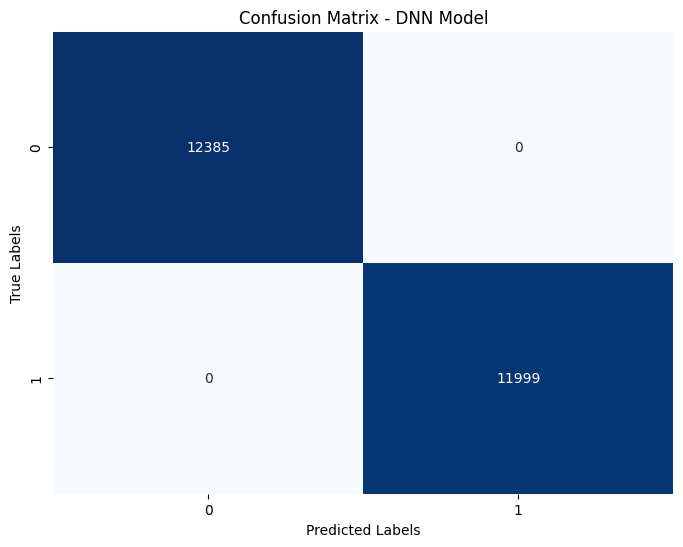

In [150]:
# Predictions on the test set
y_pred = best_dnn_model.predict(X_test)

# Convert predictions to binary (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - DNN Model')
plt.show()


**ANN MODEL**

In [151]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# Define a function to create the ANN model
def create_ann_model(optimizer='adam', hidden_units=64, activation='relu'):
    model = keras.Sequential()
    model.add(layers.Dense(hidden_units, activation=activation, input_dim=X_train.shape[1]))
    model.add(layers.Dense(hidden_units, activation=activation))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Create a KerasClassifier
model = KerasClassifier(build_fn=create_ann_model, verbose=0)

# Define hyperparameters to search
param_grid = {
    'optimizer': ['adam', 'sgd'],
    'hidden_units': [32, 64, 128],
    'activation': ['relu', 'tanh']
}

# Perform grid search with cross-validation
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

# Print the best hyperparameters and accuracy
print("Best Hyperparameters: ", grid_result.best_params_)
print("Best Accuracy: {:.2f}%".format(grid_result.best_score_ * 100))


/tmp/ipykernel_32/2571299855.py:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_ann_model, verbose=0)


Best Hyperparameters:  {'activation': 'relu', 'hidden_units': 128, 'optimizer': 'adam'}
Best Accuracy: 99.93%


In [152]:
from tensorflow import keras

# Define a function to create the ANN model with the best hyperparameters
def create_ann_model(hidden_units=128, activation='relu', optimizer='adam'):
    model = keras.Sequential()
    model.add(keras.layers.Dense(hidden_units, activation=activation, input_dim=X_train.shape[1]))
    model.add(keras.layers.Dense(32, activation=activation))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Use the best hyperparameters from the grid search
best_hidden_units = best_params['hidden_units']
best_activation = best_params['activation']
best_optimizer = best_params['optimizer']

# Create the ANN model with the best hyperparameters
best_ann_model = create_ann_model(hidden_units=best_hidden_units, activation=best_activation, optimizer=best_optimizer)

# Train the ANN model with the best hyperparameters
best_ann_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the ANN model with the best hyperparameters
test_loss_best_ann, test_accuracy_best_ann = best_ann_model.evaluate(X_test, y_test)
print(f'Best ANN Test Accuracy: {test_accuracy_best_ann}')


Epoch 1/10
3556/3556 [==============================] - 8s 2ms/step - loss: 0.0100 - accuracy: 0.9988 - val_loss: 0.0030 - val_accuracy: 0.9994
Epoch 2/10
3556/3556 [==============================] - 7s 2ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 3/10
3556/3556 [==============================] - 7s 2ms/step - loss: 8.0721e-04 - accuracy: 0.9998 - val_loss: 2.0724e-04 - val_accuracy: 1.0000
Epoch 4/10
3556/3556 [==============================] - 7s 2ms/step - loss: 2.4662e-04 - accuracy: 1.0000 - val_loss: 9.9236e-05 - val_accuracy: 1.0000
Epoch 5/10
3556/3556 [==============================] - 8s 2ms/step - loss: 1.7554e-04 - accuracy: 1.0000 - val_loss: 2.2147e-05 - val_accuracy: 1.0000
Epoch 6/10
3556/3556 [==============================] - 7s 2ms/step - loss: 1.2195e-05 - accuracy: 1.0000 - val_loss: 6.1840e-06 - val_accuracy: 1.0000
Epoch 7/10
3556/3556 [==============================] - 7s 2ms/step - loss: 3.2939e-06 - accuracy: 1.000

762/762 [==============================] - 1s 1ms/step


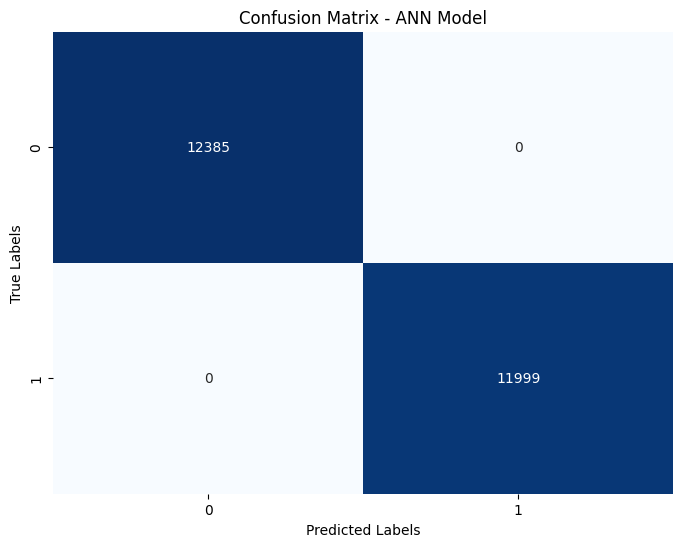

In [153]:


# Predictions on the test set
y_pred_ann = best_ann_model.predict(X_test)

# Convert predictions to binary (0 or 1)
y_pred_binary_ann = (y_pred_ann > 0.5).astype(int)

# Confusion Matrix
conf_matrix_ann = confusion_matrix(y_test, y_pred_binary_ann)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ann, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - ANN Model')
plt.show()


[0]	validation-logloss:0.59815
[1]	validation-logloss:0.52035
[2]	validation-logloss:0.45548
[3]	validation-logloss:0.40063
[4]	validation-logloss:0.35379
[5]	validation-logloss:0.31343
[6]	validation-logloss:0.27843
[7]	validation-logloss:0.24790
[8]	validation-logloss:0.22114
[9]	validation-logloss:0.19761
[10]	validation-logloss:0.17683
[11]	validation-logloss:0.15843
[12]	validation-logloss:0.14210
[13]	validation-logloss:0.12758
[14]	validation-logloss:0.11464
[15]	validation-logloss:0.10309
[16]	validation-logloss:0.09276
[17]	validation-logloss:0.08352
[18]	validation-logloss:0.07523
[19]	validation-logloss:0.06780
[20]	validation-logloss:0.06113
[21]	validation-logloss:0.05514
[22]	validation-logloss:0.04975
[23]	validation-logloss:0.04490
[24]	validation-logloss:0.04053
[25]	validation-logloss:0.03660
[26]	validation-logloss:0.03306
[27]	validation-logloss:0.02986
[28]	validation-logloss:0.02698
[29]	validation-logloss:0.02439
[30]	validation-logloss:0.02204
[31]	validation-lo

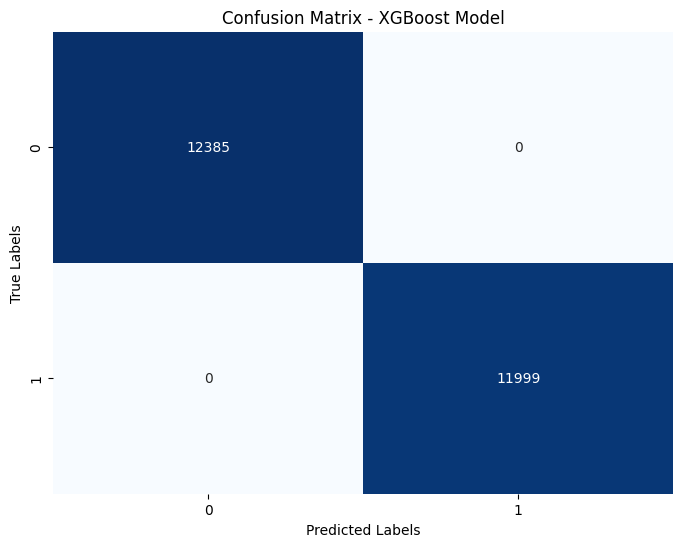

In [154]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report


# Create DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

# Set Hyperparameters
params = {
    'objective': 'binary:logistic',  # For binary classification
    'max_depth': 3,                # Adjust this value
    'learning_rate': 0.1,          # Adjust this value
    'eval_metric': 'logloss'
}

# Training
xgb_model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dval, 'validation')])

# Predictions
y_pred = xgb_model.predict(dtest)

# Evaluation
predictions = [round(value) for value in y_pred]
xgb_accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print(f' XGBoost Accuracy: {xgb_accuracy}')
print(report)
# Confusion Matrix for XGBoost
conf_matrix_xgb = confusion_matrix(y_test, predictions)

# Plot Confusion Matrix for XGBoost
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - XGBoost Model')
plt.show()

LR Model Accuracy: 0.9988106955380578
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12385
           1       1.00      1.00      1.00     11999

    accuracy                           1.00     24384
   macro avg       1.00      1.00      1.00     24384
weighted avg       1.00      1.00      1.00     24384



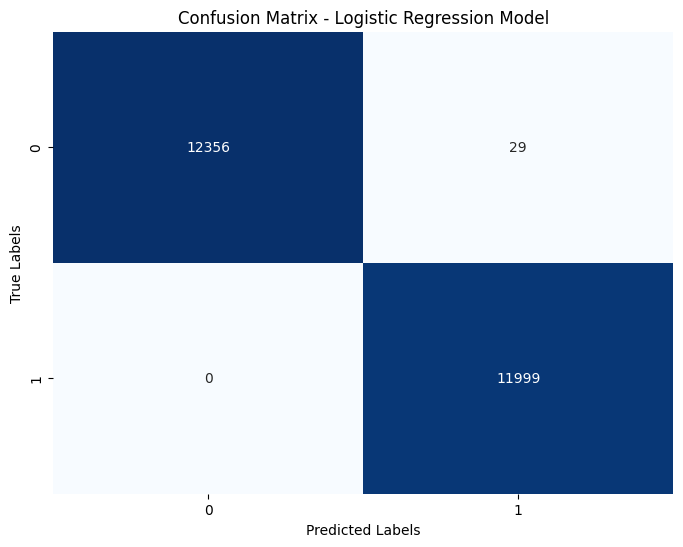

In [155]:
from sklearn.linear_model import LogisticRegression

# Create a logistic regression model
lr_model = LogisticRegression()

# Fit the model to the training data
lr_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_lr = lr_model.predict(X_test)

# Calculate accuracy and generate a classification report
lr_accuracy = accuracy_score(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr)

# Confusion Matrix for Logistic Regression
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

# Print the results
print(f'LR Model Accuracy: {lr_accuracy}')
print(report_lr)

# Display Confusion Matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Logistic Regression Model')
plt.show()


In [156]:
import pandas as pd

# Define the test accuracy values for each model
test_accuracy_dnn = test_accuracy_best_dnn
test_accuracy_ann = test_accuracy_best_ann
test_accuracy_xgboost = xgb_accuracy 
test_accuracy_lr = lr_accuracy 

# Create a dictionary with the accuracy results
accuracy_results = {
    'Model': ['DNN', 'ANN', 'XGBoost', 'LR'],
    'Test Accuracy': [test_accuracy_dnn, test_accuracy_ann, test_accuracy_xgboost, test_accuracy_lr]
}

# Create a DataFrame from the dictionary
accuracy_df = pd.DataFrame(accuracy_results)

# Display the accuracy results table
print(accuracy_df)


     Model  Test Accuracy
0      DNN       1.000000
1      ANN       1.000000
2  XGBoost       1.000000
3       LR       0.998811


In [157]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report


# Isolation Forest
iso_forest = IsolationForest(contamination=0.01)  # Adjust the contamination parameter based on your data
iso_forest.fit(X_train)

# Predictions on the test set
iso_forest_preds = iso_forest.predict(X_test)

# Convert predictions to binary labels (1 for normal, -1 for anomaly)
iso_forest_preds_binary = np.where(iso_forest_preds == 1, 0, 1)

# Confusion Matrix and Classification Report
print("Confusion Matrix for Isolation Forest:\n")
print(confusion_matrix(y_test, iso_forest_preds_binary))
print("\nClassification Report for Isolation Forest:\n")
print(classification_report(y_test, iso_forest_preds_binary))


Confusion Matrix for Isolation Forest:

[[12385     0]
 [11777   222]]

Classification Report for Isolation Forest:

              precision    recall  f1-score   support

           0       0.51      1.00      0.68     12385
           1       1.00      0.02      0.04     11999

    accuracy                           0.52     24384
   macro avg       0.76      0.51      0.36     24384
weighted avg       0.75      0.52      0.36     24384



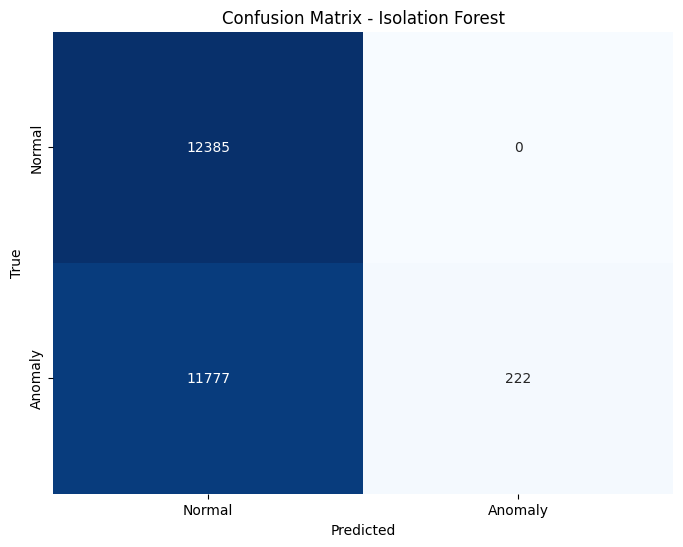

In [158]:
# Confusion Matrix
conf_mat_iso_forest = confusion_matrix(y_test, iso_forest_preds_binary)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_iso_forest, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Isolation Forest')
plt.show()

In [159]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, classification_report


# Local Outlier Factor (LOF)
lof = LocalOutlierFactor(novelty=True)
lof.fit(X_train)

# Predictions on the test set
lof_preds = lof.predict(X_test)

# Convert predictions to binary labels (1 for normal, -1 for anomaly)
lof_preds_binary = np.where(lof_preds == 1, 0, 1)

# Confusion Matrix and Classification Report
print("Confusion Matrix for Local Outlier Factor:\n")
print(confusion_matrix(y_test, lof_preds_binary))
print("\nClassification Report for Local Outlier Factor:\n")
print(classification_report(y_test, lof_preds_binary))


Confusion Matrix for Local Outlier Factor:

[[12356    29]
 [11976    23]]

Classification Report for Local Outlier Factor:

              precision    recall  f1-score   support

           0       0.51      1.00      0.67     12385
           1       0.44      0.00      0.00     11999

    accuracy                           0.51     24384
   macro avg       0.48      0.50      0.34     24384
weighted avg       0.48      0.51      0.34     24384



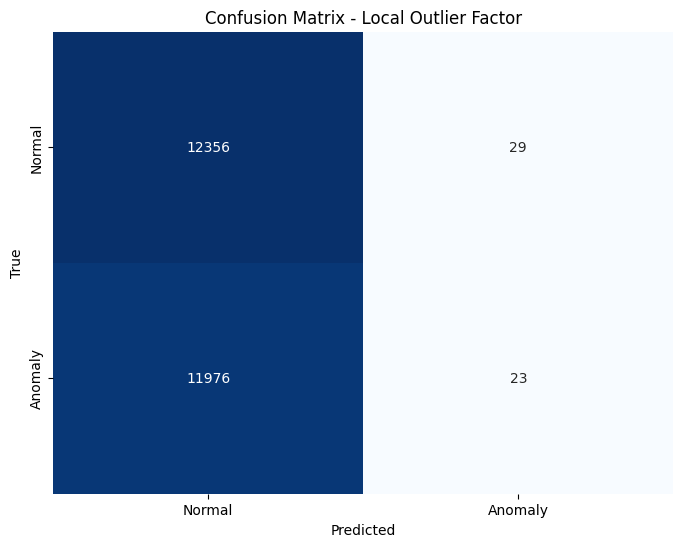

In [160]:


# Confusion Matrix
conf_mat_lof = confusion_matrix(y_test, lof_preds_binary)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_lof, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Local Outlier Factor')
plt.show()


In [161]:
 from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix, classification_report


# One-Class SVM
one_class_svm = OneClassSVM(nu=0.01)  # Adjust the nu parameter based on your data
one_class_svm.fit(X_train)

# Predictions on the test set
one_class_svm_preds = one_class_svm.predict(X_test)

# Convert predictions to binary labels (1 for normal, -1 for anomaly)
one_class_svm_preds_binary = np.where(one_class_svm_preds == 1, 0, 1)

# Confusion Matrix and Classification Report
print("Confusion Matrix for One-Class SVM:\n")
print(confusion_matrix(y_test, one_class_svm_preds_binary))
print("\nClassification Report for One-Class SVM:\n")
print(classification_report(y_test, one_class_svm_preds_binary))


Confusion Matrix for One-Class SVM:

[[12315    70]
 [11823   176]]

Classification Report for One-Class SVM:

              precision    recall  f1-score   support

           0       0.51      0.99      0.67     12385
           1       0.72      0.01      0.03     11999

    accuracy                           0.51     24384
   macro avg       0.61      0.50      0.35     24384
weighted avg       0.61      0.51      0.36     24384



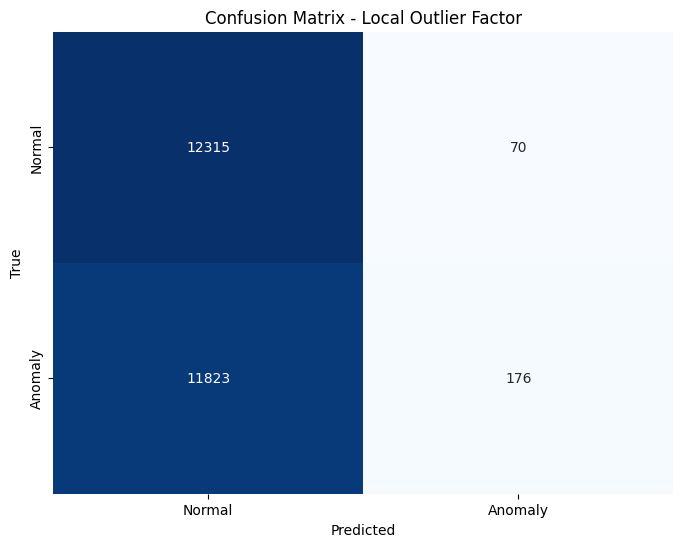

In [162]:


# Confusion Matrix
conf_mat_SVM = confusion_matrix(y_test, one_class_svm_preds_binary)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_SVM, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Local Outlier Factor')
plt.show()
